Outline

[Preliminary](#preliminary)<br>
[Clean & Merge](#clean--merge)<br>
[Feature engineering](#feature-engineering)<br>
[Graphical Analysis](#graphical-analysis)<br>
[Modelling](#modelling)<br>


# Preliminary

In [1]:
import re
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil import tz

data_directory = '../../RawFiles'
melbourne_tz = tz.gettz('Australia/Melbourne')

sns.set()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x if int(x) != x else '%d' % int(x))


class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)



<a id='Clean_Merge'></a>

# Clean & Merge

channel_cd	voltage_lvt	amps	power_factor_pf	number_of_phases	overground_or_underground	make	model	charger	drive_kms	has_ev

In [2]:
def append_csvs_into_df(file_pattern: str, ignore_index: bool = True, sort: bool = False):
    data_frames = []
    for file in glob.glob(file_pattern):
        print(f'loading: {file}')
        data_frames.append(pd.read_csv(file))
    full_dataset = pd.concat(data_frames, ignore_index=ignore_index, sort=sort)
    return full_dataset


def simple_col_name(x):
    x = x.lower().strip()
    return {'meter_id': 'meter',
            'start_timestamptz_ts': 'time',
            'interval_ts': 'time',
            'active_consumption_kwh': 'consumption',
            'active_generation_kwh': 'generation',
            'ev make': 'make',
            'ev model': 'model',
            "amps_lct": 'amps',
            'ev wall charger installed?': 'charger',
            'how many kms do you usually drive each year? \n(prior to the covid-19 pandemic)': 'drive_kms',
            'power_factor_pf': 'power_factor',
            'channel_cd': 'channel',
            'voltage_lvt': 'voltage',
            'number_of_phases': 'phases',
            'overground_or_underground': 'infrast',
            }.setdefault(x, x)
    
def generate_datetime_vars(df, to_create=None, timecol = 'time'):
    """add useful datetime attributes to dataframe df"""
    to_create = to_create or ['dayofyear', 'weekofyear', 'dayofweek', 'day', 'month', 'year']
    datetime_accessor = df[timecol].dt
    for col in to_create:
        df[col] = getattr(datetime_accessor, col)
    if 'dayofweek' in to_create:
        df['weekend'] = np.where(df['dayofweek'] > 4, 1, 0)


<h1> 1- EV Meters list (those who have EV) </h1>

In [3]:
df_with_ev = pd.read_excel(f'{data_directory}/EV_training_meters_list.xlsx').rename(columns=simple_col_name).drop(columns=['kms_group'])
meters_with_ev = df_with_ev['meter'].to_list()
df_with_ev['has_ev'] = 1
df_with_ev.head()


meter     make                model charger            drive_kms  has_ev
0  14702    Tesla  Model 3 and Model X     Yes  Greater than 20,000       1
1  21463   Nissan                 Leaf      No      5,000 to 10,000       1
2  63317  Nissan                  Leaf      No      5,000 to 10,000       1
3  69825  Jaguar                 ipace     Yes     10,000 to 15,000       1
4  98536   Jaguar                ipace      No     15,000 to 20,000       1


<h1> 2- Consumption datasets </h1>


In [4]:
# append & rename
df_consumption = append_csvs_into_df(f"{data_directory}/*consumption*nov*21*csv").drop(['Unnamed: 0'], axis=1).rename(
    columns=simple_col_name)
# dates
df_consumption['time'] = pd.to_datetime(df_consumption['time'], infer_datetime_format=True, utc=True).dt.tz_convert(
    melbourne_tz)
# date attributes
generate_datetime_vars(df_consumption)
# drop element_uuid
df_consumption = df_consumption.groupby(['meter', 'time']).sum().reset_index()
df_consumption['total_consumption'] = df_consumption[['consumption', 'generation']].sum(axis=1, skipna=True)
# merge with known EVs
df_consumption = pd.merge(left=df_consumption, right=df_with_ev, on='meter', how='outer')
# has_ev
df_consumption['has_ev'] = df_consumption['has_ev'].fillna(0).astype('int')
# needed later
meters_with_no_ev = list(set(df_consumption['meter'].unique().tolist()) - set(meters_with_ev))
# index
df_consumption.sort_values(['meter', 'time'], inplace=True, ignore_index=True)
# .drop_duplicates(subset=['meter', 'time'], keep=False).drop('element_uuid', axis=1)\
# .set_index(['time'])\
# .groupby('meter')\
# .resample('5T', closed='right', label='right')\
# .ffill().drop('meter', axis=1)
df_consumption.head()



loading: ../../RawFiles\consumption_training_data_nov21.csv


C:\Users\khalil\AppData\Local\Temp/ipykernel_7992/4117131605.py:34: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[col] = getattr(datetime_accessor, col)


meter                      time  consumption  generation  dayofyear  \
0    396 2021-11-01 11:00:00+11:00      0.04370           0        305   
1    396 2021-11-01 11:30:00+11:00      0.07500           0        305   
2    396 2021-11-01 12:00:00+11:00      0.11870           0        305   
3    396 2021-11-01 12:30:00+11:00      0.05620           0        305   
4    396 2021-11-01 13:00:00+11:00      0.04370           0        305   

   weekofyear  dayofweek  day  month  year  weekend  total_consumption make  \
0          44          0    1     11  2021        0            0.04370  NaN   
1          44          0    1     11  2021        0            0.07500  NaN   
2          44          0    1     11  2021        0            0.11870  NaN   
3          44          0    1     11  2021        0            0.05620  NaN   
4          44          0    1     11  2021        0            0.04370  NaN   

  model charger drive_kms  has_ev  
0   NaN     NaN       NaN       0  
1   NaN     NaN       NaN       0  
2   NaN     NaN       NaN       0  
3   NaN     NaN       NaN       0  
4   NaN     NaN       NaN       0

<h1> 3- Power quality datasets </h1>

In [5]:
# power quality datasets
# append & rename
df_power_quality = append_csvs_into_df(f"{data_directory}/power_quality*nov*21*csv").drop(['Unnamed: 0'],
                                                                                           axis=1).rename(
    columns=simple_col_name)
# proper types
df_power_quality['time'] = pd.to_datetime(df_power_quality['time'], infer_datetime_format=True, utc=True).dt.tz_convert(
    melbourne_tz)
generate_datetime_vars(df_power_quality)
df_power_quality['abs_power_factor'] = np.abs(df_power_quality['power_factor'])
obj_columns = df_power_quality.select_dtypes(include='object').columns
df_power_quality[obj_columns] = df_power_quality[obj_columns].astype('category')
# merge with known EVs
df_power_quality = pd.merge(left=df_power_quality, right=df_with_ev, on='meter', how='outer')
df_power_quality['has_ev'] = df_power_quality['has_ev'].fillna(0).astype('int')
# sort
df_power_quality.sort_values(['meter', 'time', 'channel'], inplace=True, ignore_index=True)
df_power_quality.head()


loading: ../../RawFiles\power_quality_training_data_nov21.csv


C:\Users\khalil\AppData\Local\Temp/ipykernel_7992/4117131605.py:34: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[col] = getattr(datetime_accessor, col)


meter channel                      time   voltage    amps  power_factor  \
0    396       a 2021-11-01 00:00:00+11:00 242.47000 0.34400             1   
1    396       a 2021-11-01 00:05:00+11:00 244.95000 0.33518      -0.54300   
2    396       a 2021-11-01 00:10:00+11:00 243.59000 0.33152      -0.55200   
3    396       a 2021-11-01 00:15:00+11:00 244.58000 0.56629      -0.97300   
4    396       a 2021-11-01 00:20:00+11:00 245.43000 0.54029      -0.96800   

   phases infrast  dayofyear  weekofyear  ...  day  month  year  weekend  \
0       1      OH        305          44  ...    1     11  2021        0   
1       1      OH        305          44  ...    1     11  2021        0   
2       1      OH        305          44  ...    1     11  2021        0   
3       1      OH        305          44  ...    1     11  2021        0   
4       1      OH        305          44  ...    1     11  2021        0   

   abs_power_factor  make model charger drive_kms has_ev  
0                 1   NaN   NaN     NaN       NaN      0  
1           0.54300   NaN   NaN     NaN       NaN      0  
2           0.55200   NaN   NaN     NaN       NaN      0  
3           0.97300   NaN   NaN     NaN       NaN      0  
4           0.96800   NaN   NaN     NaN       NaN      0  

[5 rows x 21 columns]

In [37]:
list(map(len, df_consumption.groupby('has_ev')['meter'].unique()))

[1012, 60]

# Feature engineering

The Correlation between the number of times within a month the meter consumption exceeded different percentiles of consumption and probability of having EV

In [17]:
df_consumption_for_features = df_consumption.copy()
corr = []
perc = []
for q in range(50, 100, 5):
    df_consumption_for_features[f'cons_above_{q}'] = np.where(
        df_consumption_for_features['consumption'] > df_consumption_for_features['consumption'].quantile(q/100), 1, 0
        )
    aggregations = {
        f'cons_above_{q}': 'sum',
        'has_ev': 'last'
    }
    numeric_features = df_consumption_for_features.select_dtypes(exclude='object').columns
    agg_cons = df_consumption_for_features[numeric_features].reset_index().groupby('meter').aggregate(aggregations)
    corr.append(agg_cons.corr().loc['has_ev', f'cons_above_{q}'])
    perc.append(q)
# del df_consumption_for_features
pd.Series(corr, index=perc)

50   0.10823
55   0.12627
60   0.12877
65   0.13026
70   0.14560
75   0.15842
80   0.17061
85   0.18368
90   0.17760
95   0.20787
dtype: float64

The Correlation between the number of times within a month the meter current (amps) exceeded different percentiles of current and probability of having EV

In [18]:
df_power_quality_for_features = df_power_quality.copy()
corr = []
perc = []
for q in range(50, 100, 5):
    df_power_quality_for_features[f'amps_above_{q}'] = np.where(
        df_power_quality_for_features['amps'] > df_power_quality_for_features['amps'].quantile(q/100), 1, 0
        )
    aggregations = {
        f'amps_above_{q}': 'sum',
        'has_ev': 'last'
    }
    numeric_features = df_power_quality_for_features.select_dtypes(exclude='object').columns
    agg_amps = df_power_quality_for_features[numeric_features].reset_index().groupby('meter').aggregate(aggregations)
    corr.append(agg_amps.corr().loc['has_ev', f'amps_above_{q}'])
    perc.append(q)
# del df_power_quality_for_features
pd.Series(corr, index=perc)

50   0.18850
55   0.18841
60   0.20238
65   0.21507
70   0.22881
75   0.23802
80   0.24205
85   0.21552
90   0.17164
95   0.21116
dtype: float64

# Graphical Analysis

Helper functions

In [81]:
df_consumption_for_plots = df_consumption.copy().set_index(['meter', 'time'])
df_power_quality_for_plots = df_power_quality.copy().set_index(['meter', 'time'])
def subset_by_meter(meter_id: int, start: str, end: str, cols=None, cons_for_plots=None, quality_for_plots=None):
    """plot cols from cons_for_plots, quality_for_plots; both should be indexed by meter and time. That for specific meter from start to end"""
    # ensure start and end dates are within dataset range
    cols = cols or ['consumption', 'amps']

    cons_for_plots = cons_for_plots or df_consumption_for_plots
    quality_for_plots = quality_for_plots or df_power_quality_for_plots

    min_date, max_date = df_consumption_for_plots.reset_index()['time'][[0, len(df_consumption_for_plots) - 1]]
    start = max(pd.to_datetime(start).tz_localize(melbourne_tz), min_date)
    end = min(pd.to_datetime(end).tz_localize(melbourne_tz), max_date)

    df1 = df_consumption_for_plots.loc[pd.IndexSlice[meter_id, start:end], :].droplevel('meter')
    df2 = df_power_quality_for_plots.loc[pd.IndexSlice[meter_id, start:end], :].droplevel('meter')
    return pd.merge(left=df1, right=df2, left_index=True, right_index=True, how='left')[cols]


def plot_subplots_common_x(meter_data, hours_interval: int | None = None) -> None:
    """plot meter_data (better call this with output from subset_by_meter)"""
    fig, axes = plt.subplots(2, 1, figsize=(30, 12))
    # plot at a time
    for col, ax in zip(meter_data.columns, axes):
        meter_data[col].plot(ax=ax, subplots=True, x_compat=True)
        ax.set_title(col.title())
        ax.set_xlabel("")
        # X axis labels
        date_locator = mdates.DayLocator(interval=1)
        date_form = mdates.DateFormatter("%m-%d")
        ax.xaxis.grid(True, which='major', color='gray')
        ax.xaxis.set_major_locator(date_locator)
        ax.xaxis.set_major_formatter(date_form)
        ax.tick_params(axis='x', which='major', pad=20)
        if hours_interval is not None:
            hour_locator = mdates.HourLocator(interval=hours_interval)
            hour_form = mdates.DateFormatter("%H")
            ax.xaxis.set_minor_locator(hour_locator)
            ax.xaxis.set_minor_formatter(hour_form)

def plot_consumption_amps(meter, start='2021-11-15', end='2021-11-30', hours_interval=12, verbose=True):
    meter_data = subset_by_meter(meter_id=meter, start=start, end=end)
    if verbose:
        meter_info = df_with_ev[df_with_ev['meter'] == meter]
        if not meter_info.empty:
            print(meter_info)
        else:
            print('meter has no EV')

    
    fig = plot_subplots_common_x(meter_data, hours_interval=hours_interval)


Consumption and current for meters with EV between 15th and 30th November 2021

   meter   make                model charger            drive_kms  has_ev
0  14702  Tesla  Model 3 and Model X     Yes  Greater than 20,000       1


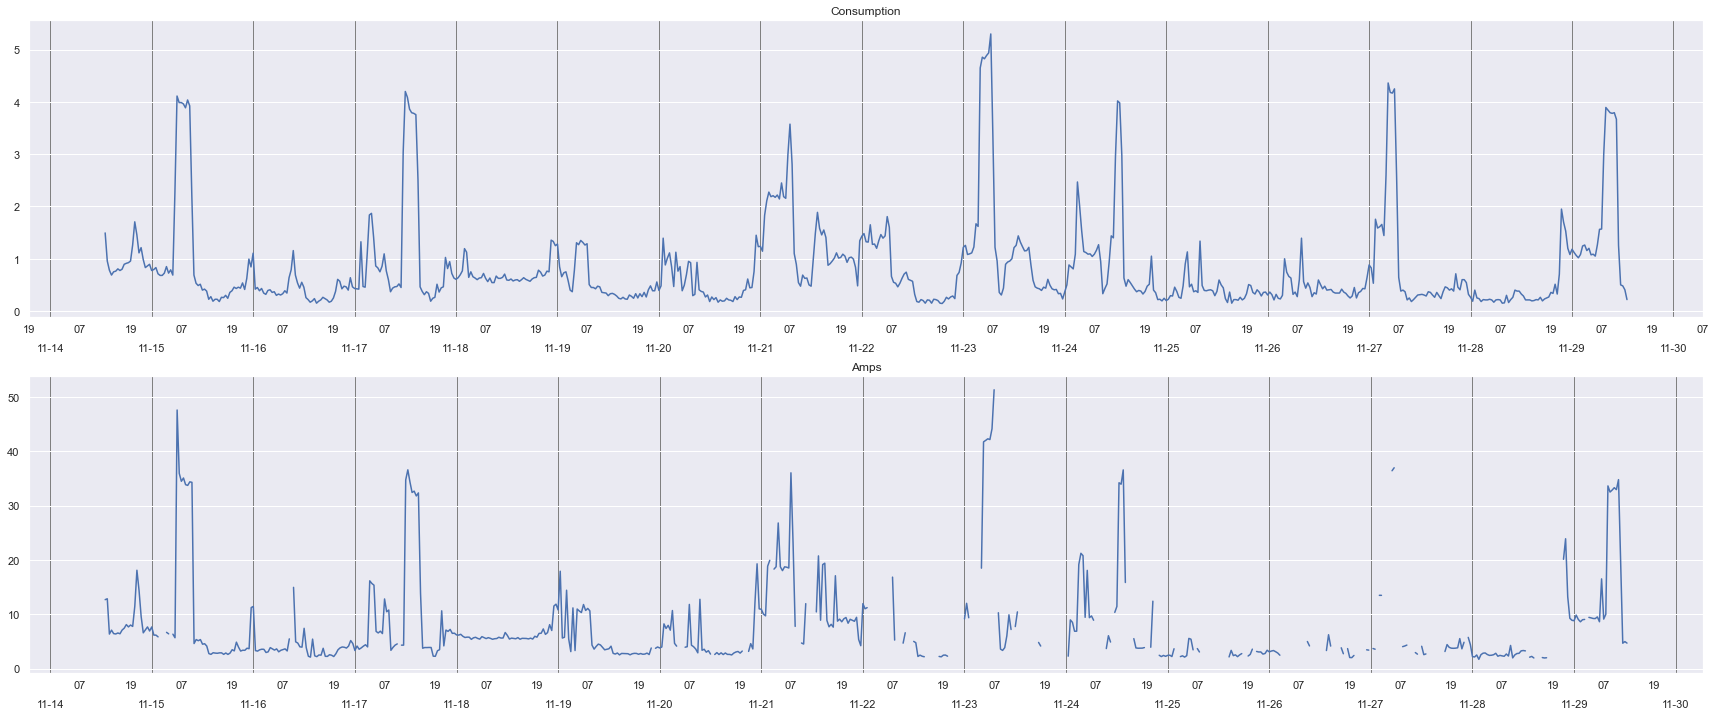

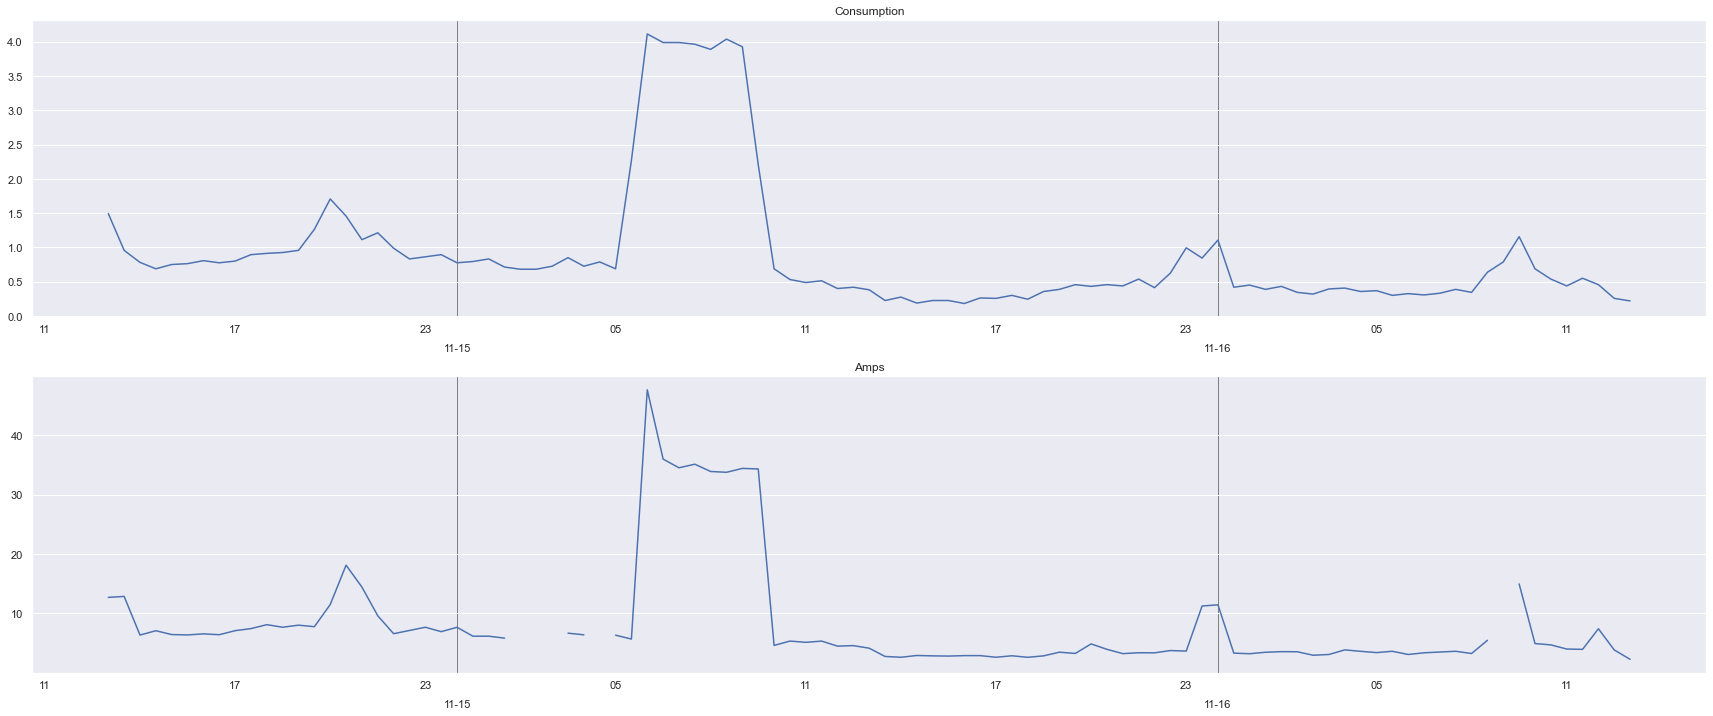

In [82]:
plot_consumption_amps(meter=meters_with_ev[0])
## example of customized plot
plot_consumption_amps(meter=meters_with_ev[0], start='2021-11-15', end='2021-11-17', hours_interval=6, verbose=False)

   meter    make model charger        drive_kms  has_ev
1  21463  Nissan  Leaf      No  5,000 to 10,000       1


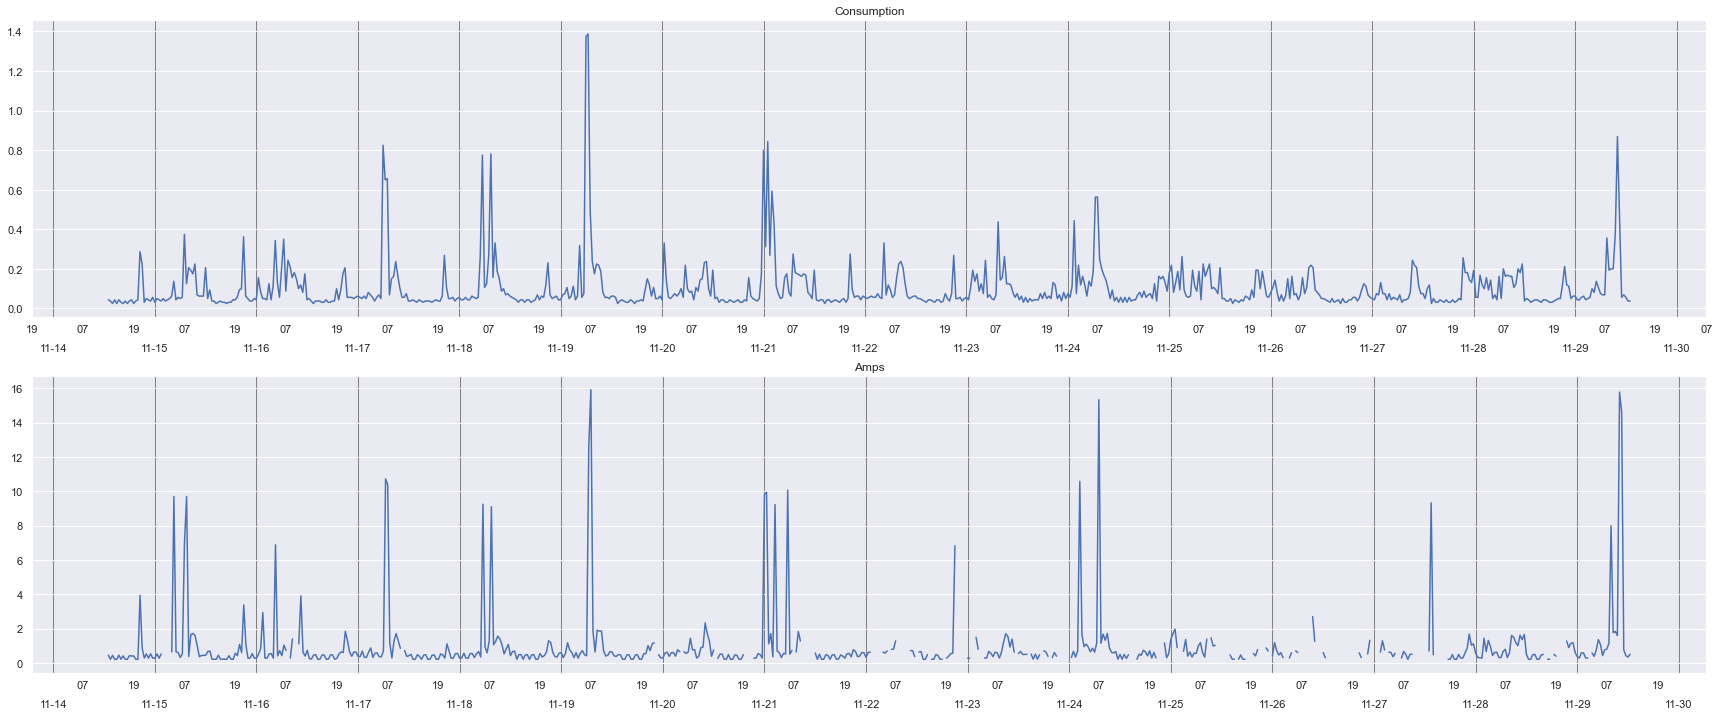

In [83]:
plot_consumption_amps(meter=meters_with_ev[1])

   meter     make model charger        drive_kms  has_ev
2  63317  Nissan   Leaf      No  5,000 to 10,000       1


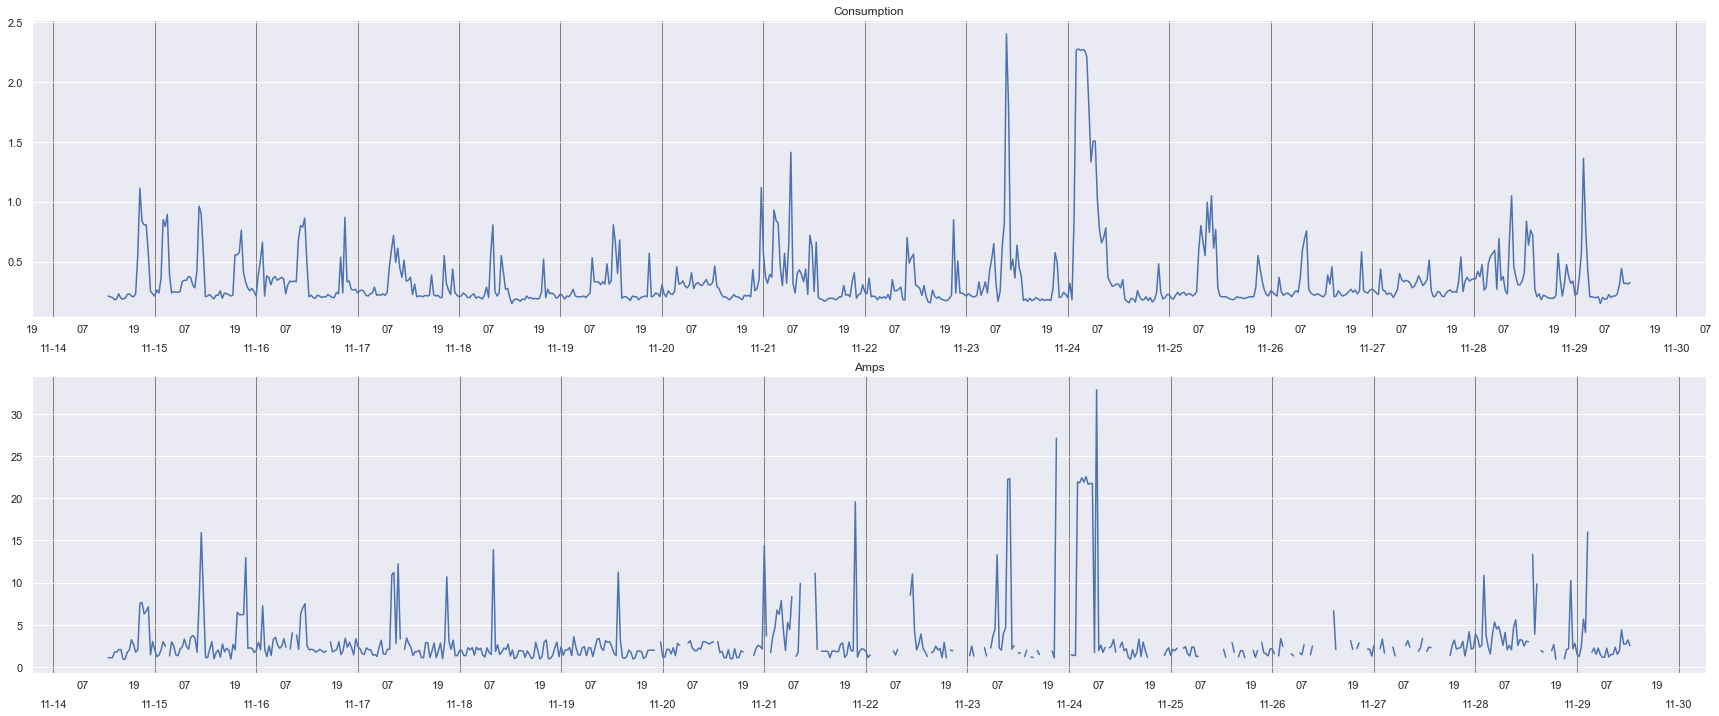

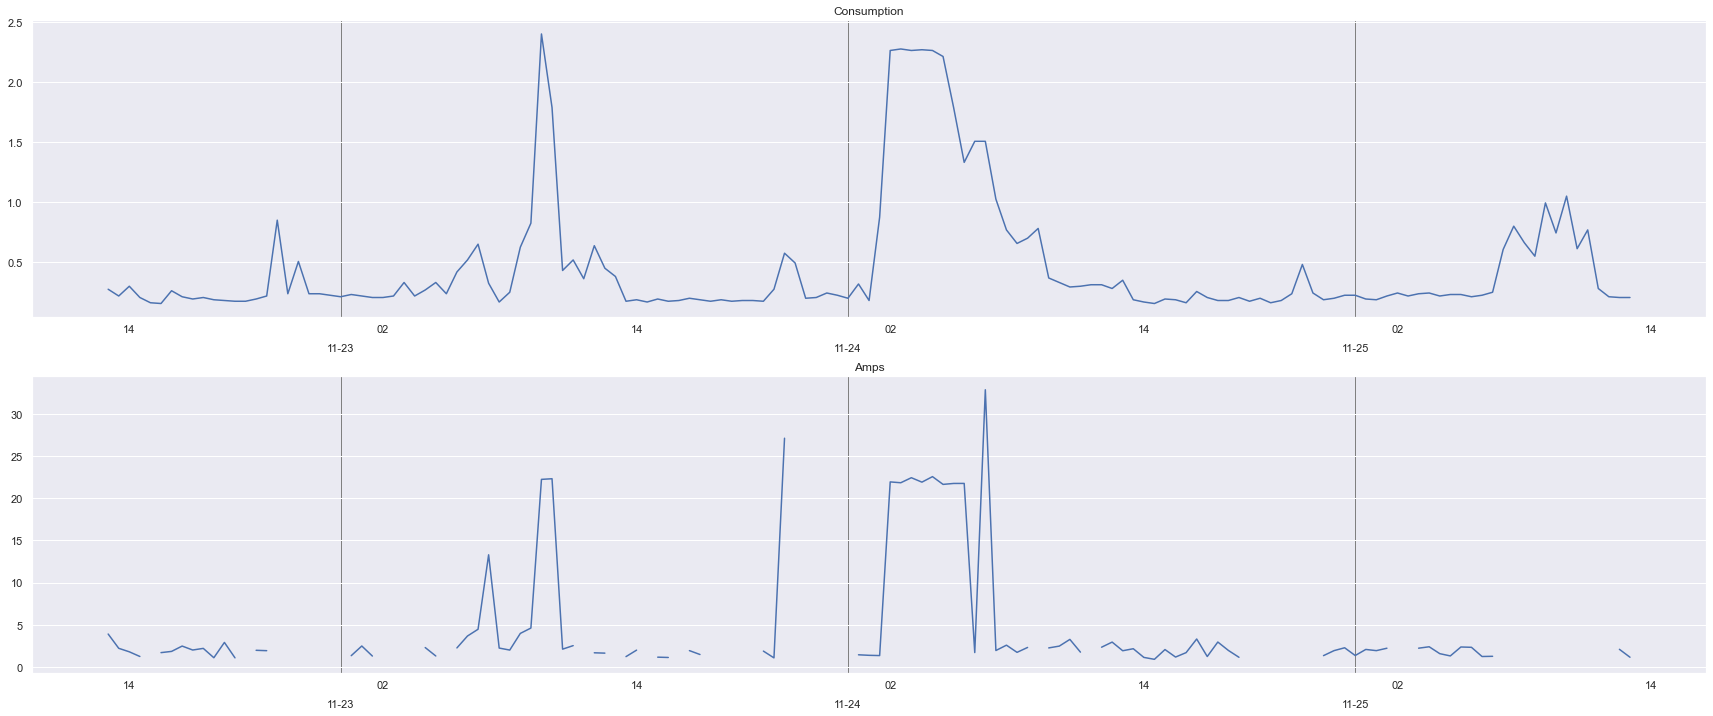

In [84]:
plot_consumption_amps(meters_with_ev[2])
plot_consumption_amps(meters_with_ev[2], start='2021-11-23', end='2021-11-26', verbose=False)

   meter     make  model charger         drive_kms  has_ev
3  69825  Jaguar   ipace     Yes  10,000 to 15,000       1


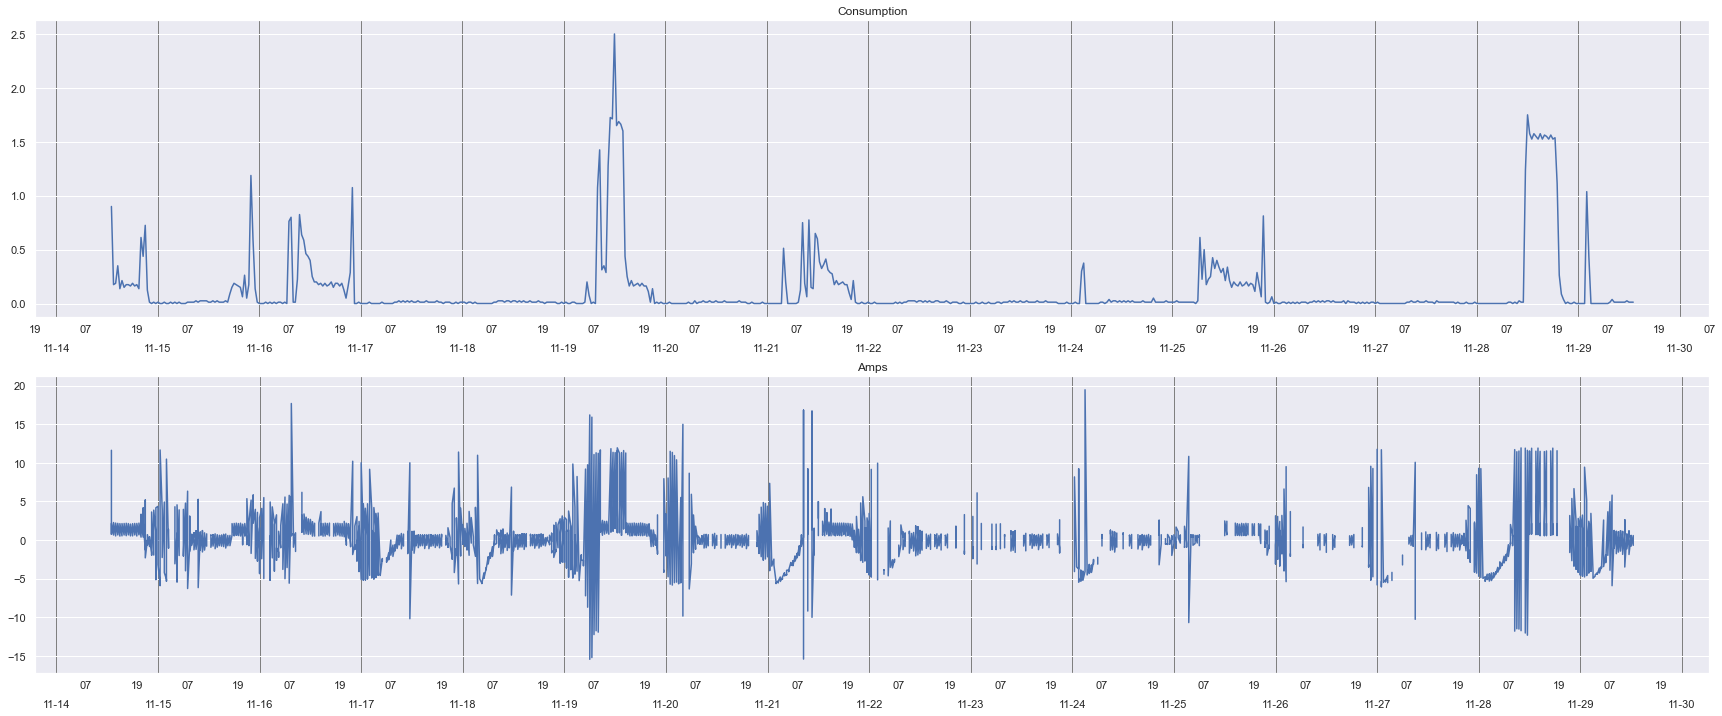

In [85]:

plot_consumption_amps(meters_with_ev[3])

In [86]:
plot_consumption_amps(meters_with_ev[4])

   meter    make  model charger         drive_kms  has_ev
4  98536  Jaguar  ipace      No  15,000 to 20,000       1


    meter   make             model charger        drive_kms  has_ev
5  102145  Tesla  Model S, Model 3     Yes  5,000 to 10,000       1


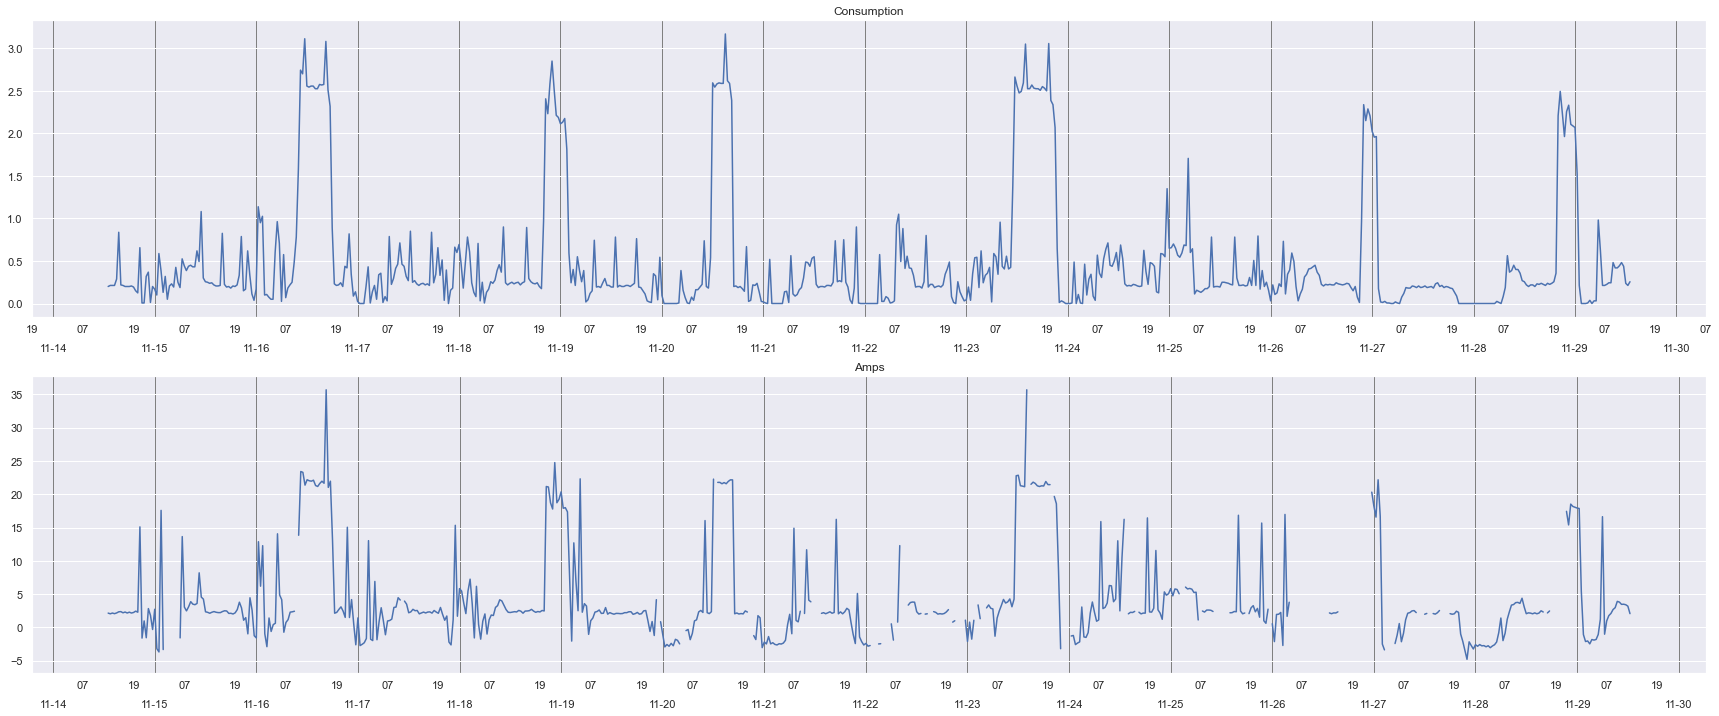

In [87]:
plot_consumption_amps(meters_with_ev[5])

In [88]:
plot_consumption_amps(meters_with_ev[6])

    meter     make  model charger         drive_kms  has_ev
6  109154  Hyundai  Ioniq     Yes  10,000 to 15,000       1


    meter     make   model charger        drive_kms  has_ev
7  120889  Renault  Zoe 40     Yes  5,000 to 10,000       1


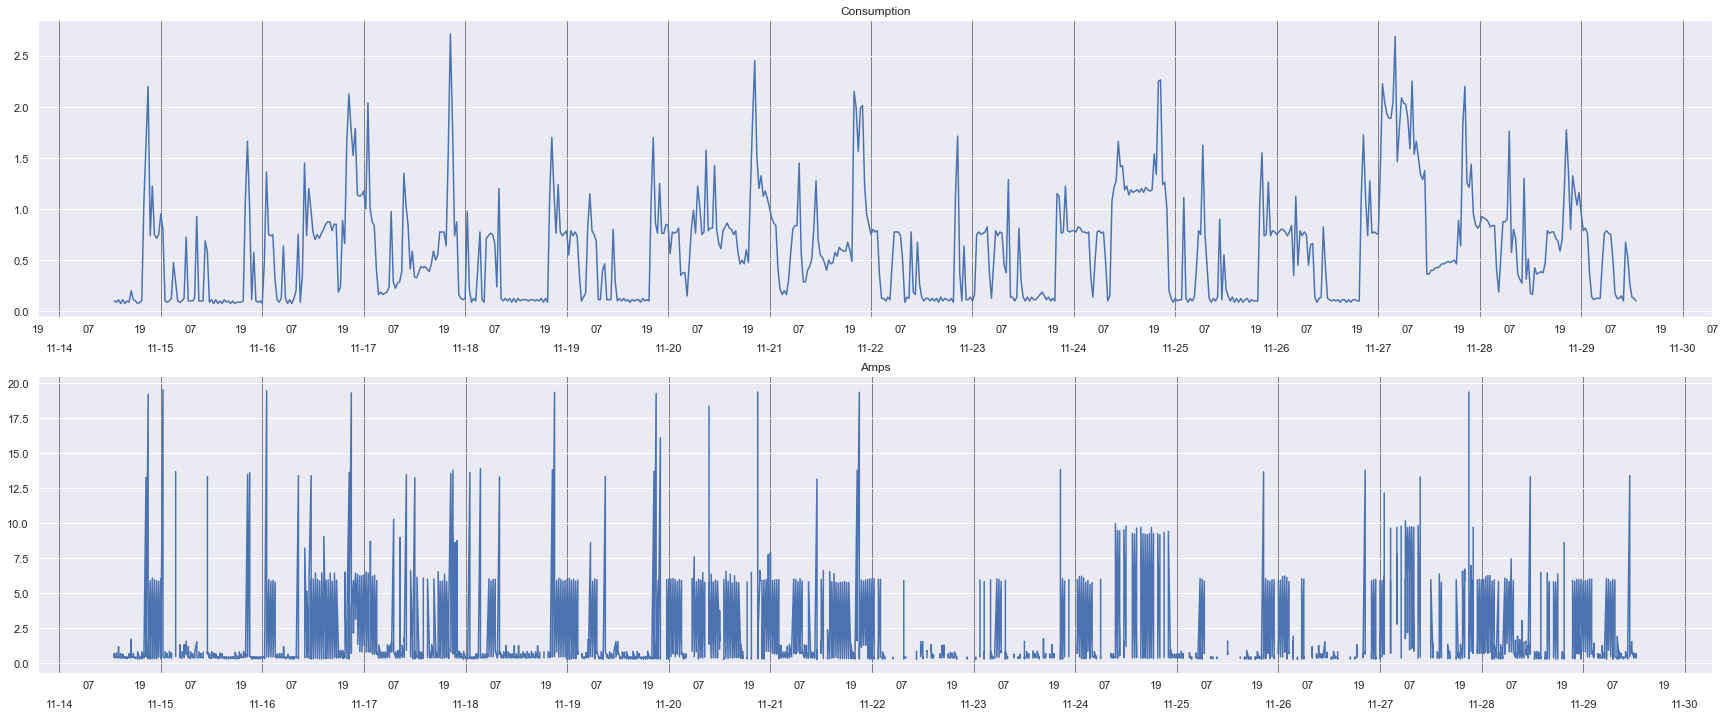

In [89]:
plot_consumption_amps(meters_with_ev[7])

    meter   make    model charger         drive_kms  has_ev
8  146262  Tesla  Model 3     Yes  15,000 to 20,000       1


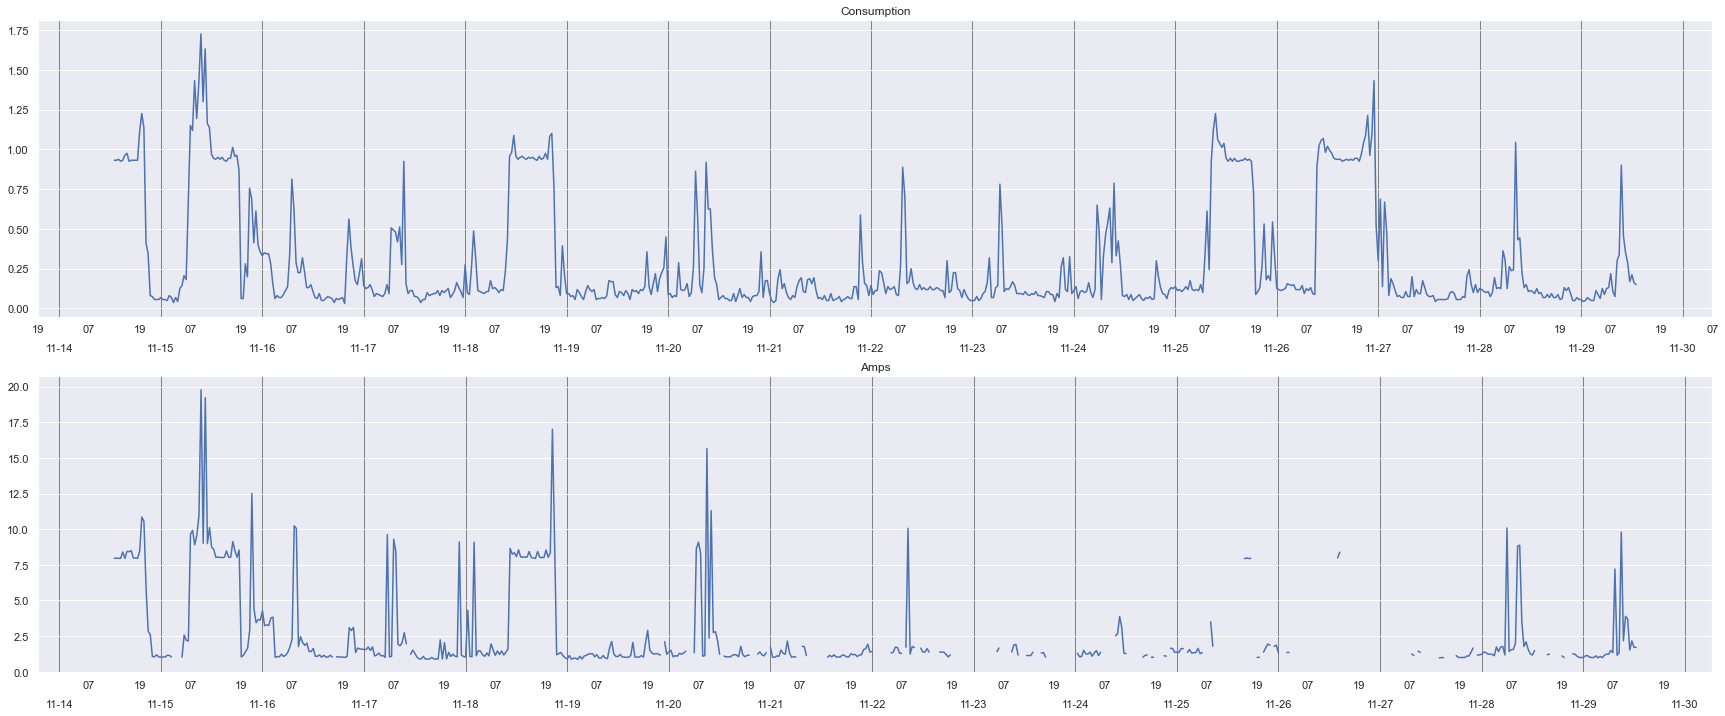

In [90]:
plot_consumption_amps(meters_with_ev[8])

    meter        make      model charger         drive_kms  has_ev
9  147369  Mitsubishi  Outlander      No  10,000 to 15,000       1


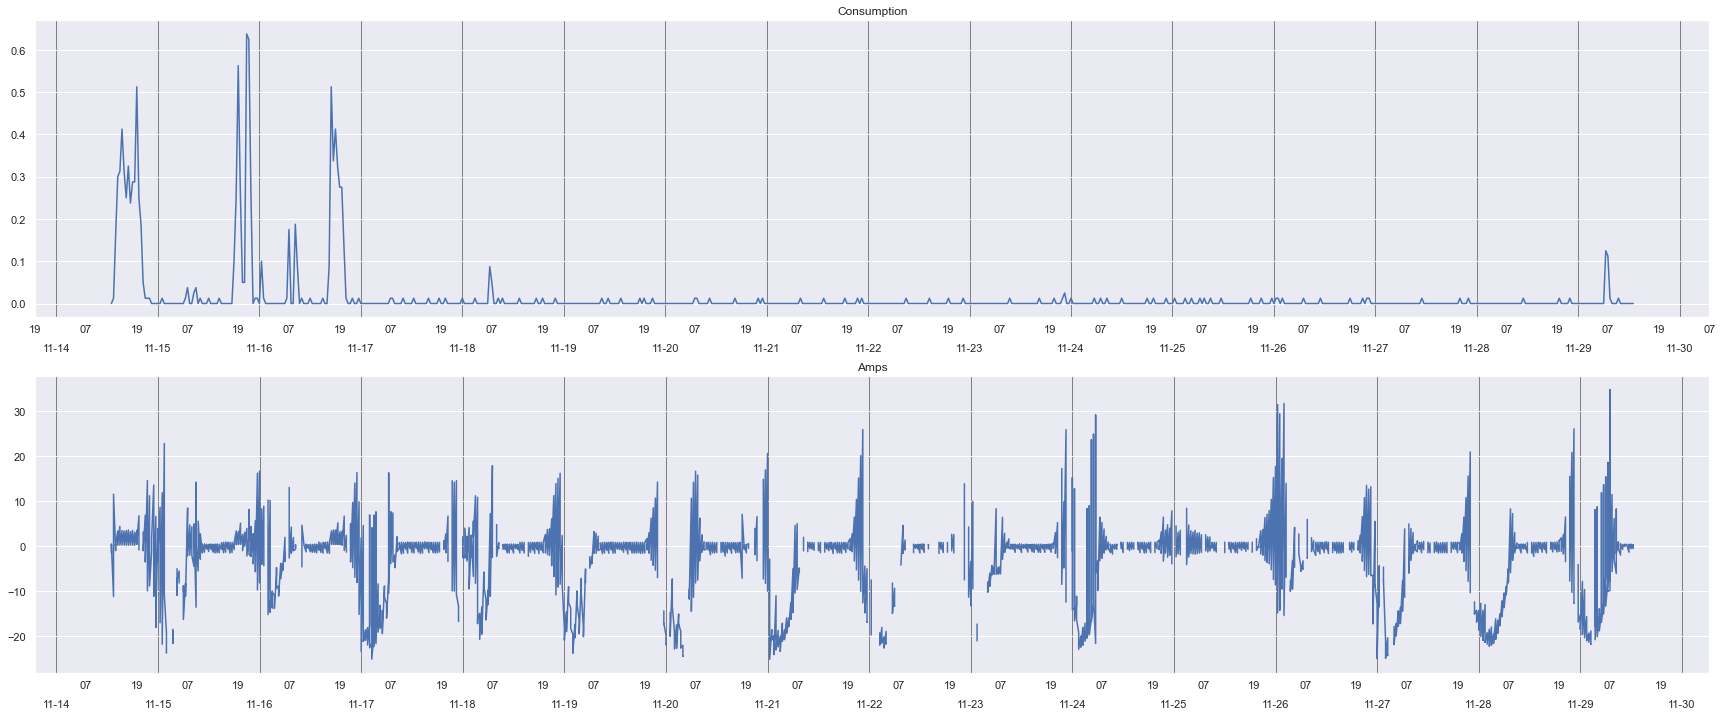

In [91]:
plot_consumption_amps(meters_with_ev[9])

In [92]:
plot_consumption_amps(meters_with_ev[10])

     meter   make    model charger            drive_kms  has_ev
10  151074  tesla  Model 3      No  Greater than 20,000       1


     meter        make      model charger         drive_kms  has_ev
11  161806  Mitsubishi  Outlander     Yes  10,000 to 15,000       1


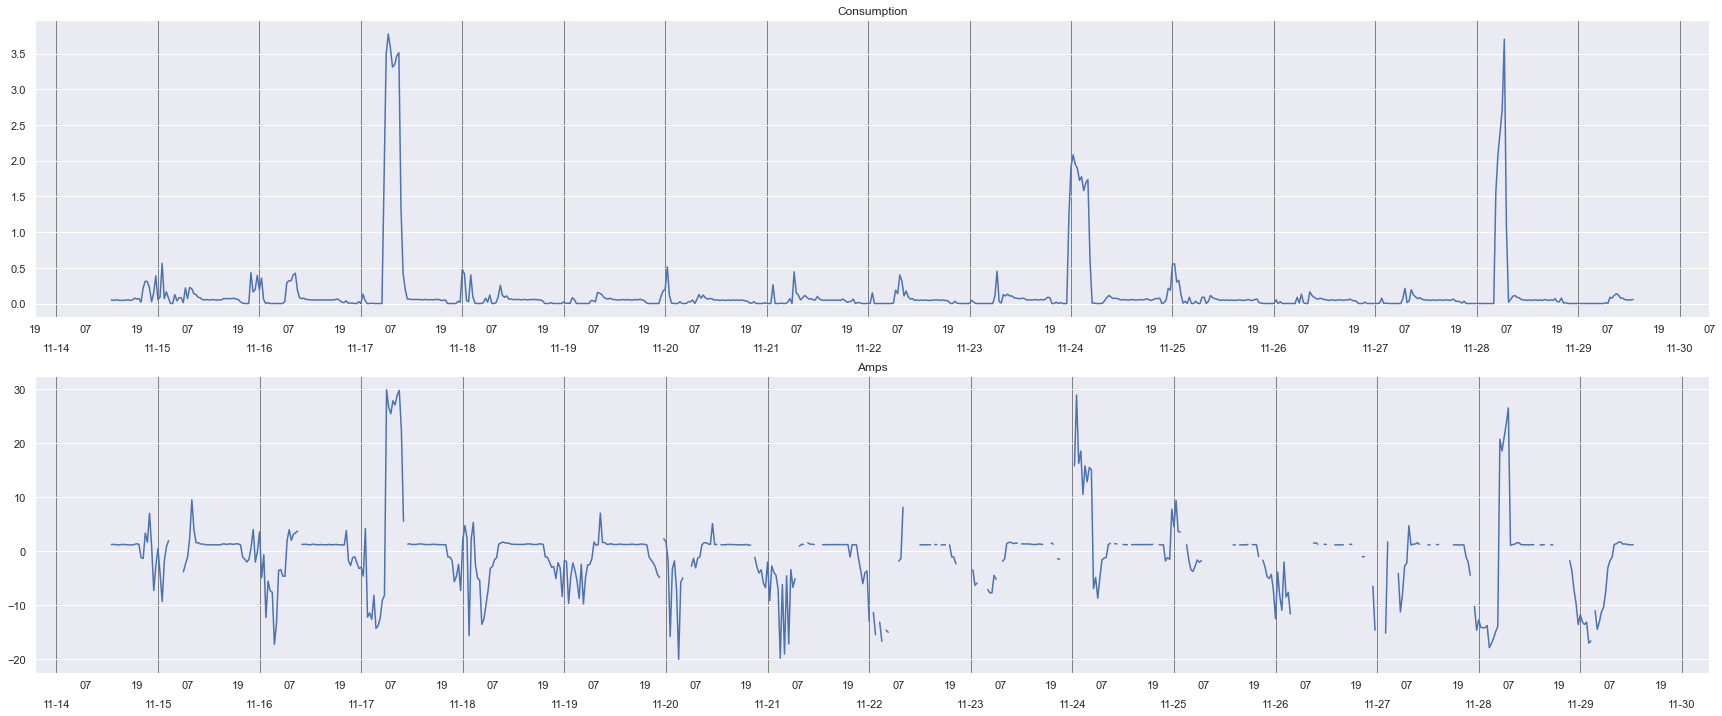

In [93]:
plot_consumption_amps(meters_with_ev[11])

In [94]:
plot_consumption_amps(meters_with_ev[12])

     meter   make    model charger            drive_kms  has_ev
12  172232  Tesla  Model 3      No  Greater than 20,000       1


     meter   make    model charger        drive_kms  has_ev
13  173927  Tesla  Model S     Yes  5,000 to 10,000       1


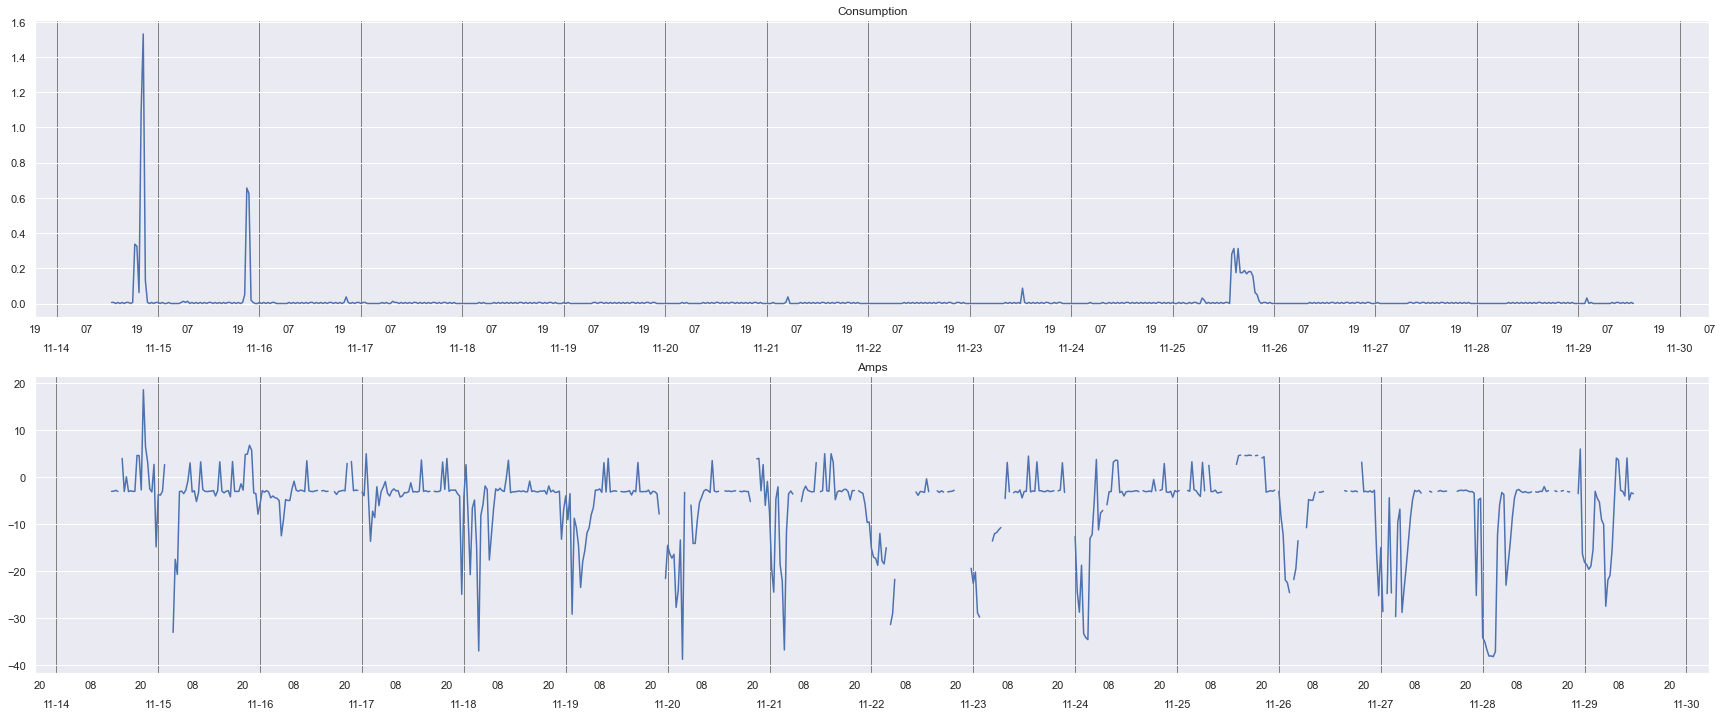

In [95]:
plot_consumption_amps(meters_with_ev[13])

     meter   make    model charger            drive_kms  has_ev
14  183009  Tesla  Model 3      No  Greater than 20,000       1


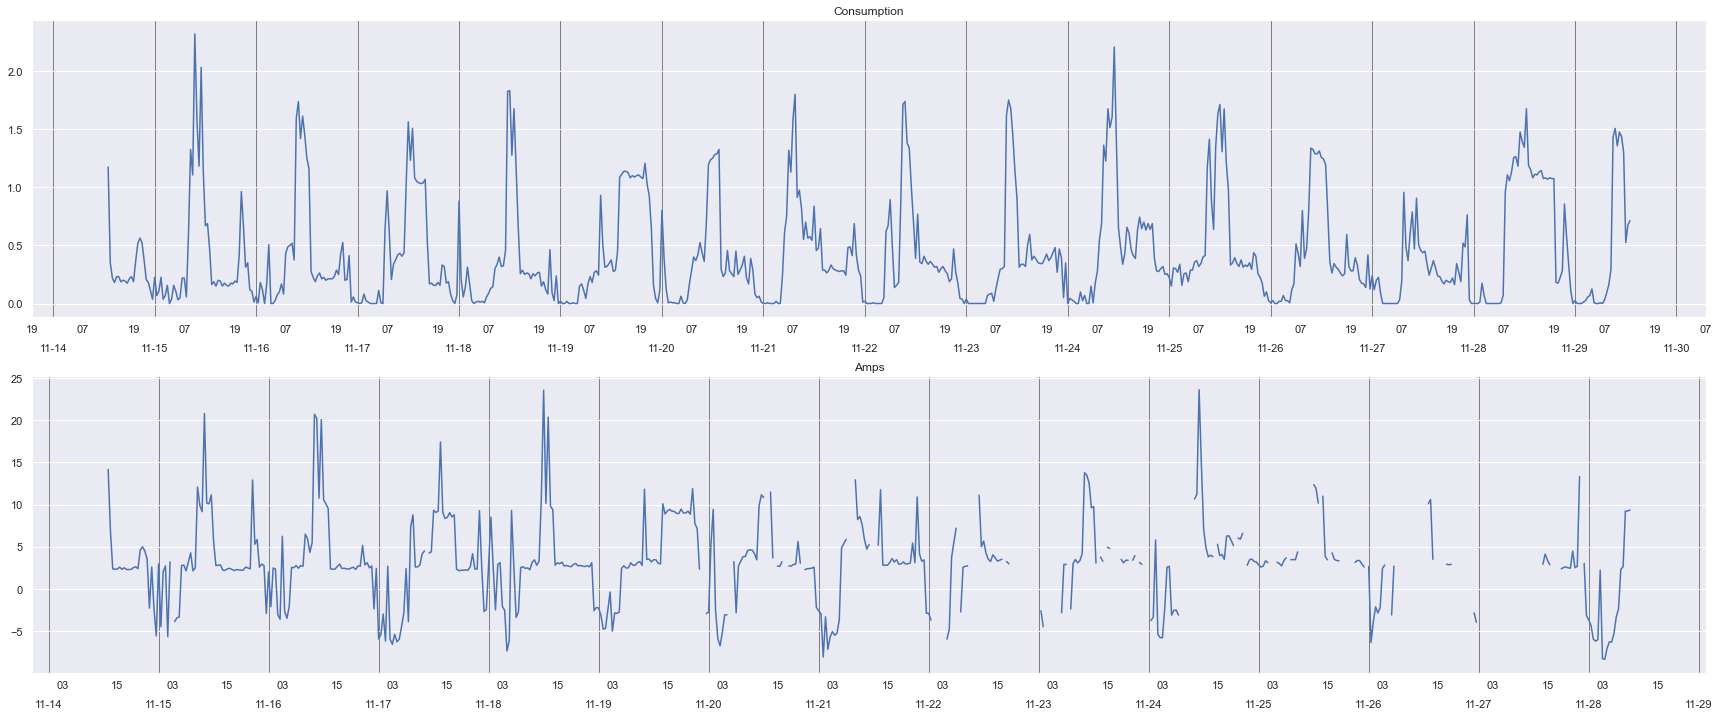

In [96]:
plot_consumption_amps(meters_with_ev[14])

     meter    make    model charger         drive_kms  has_ev
15  184799  Tesla   Model 3      No  10,000 to 15,000       1


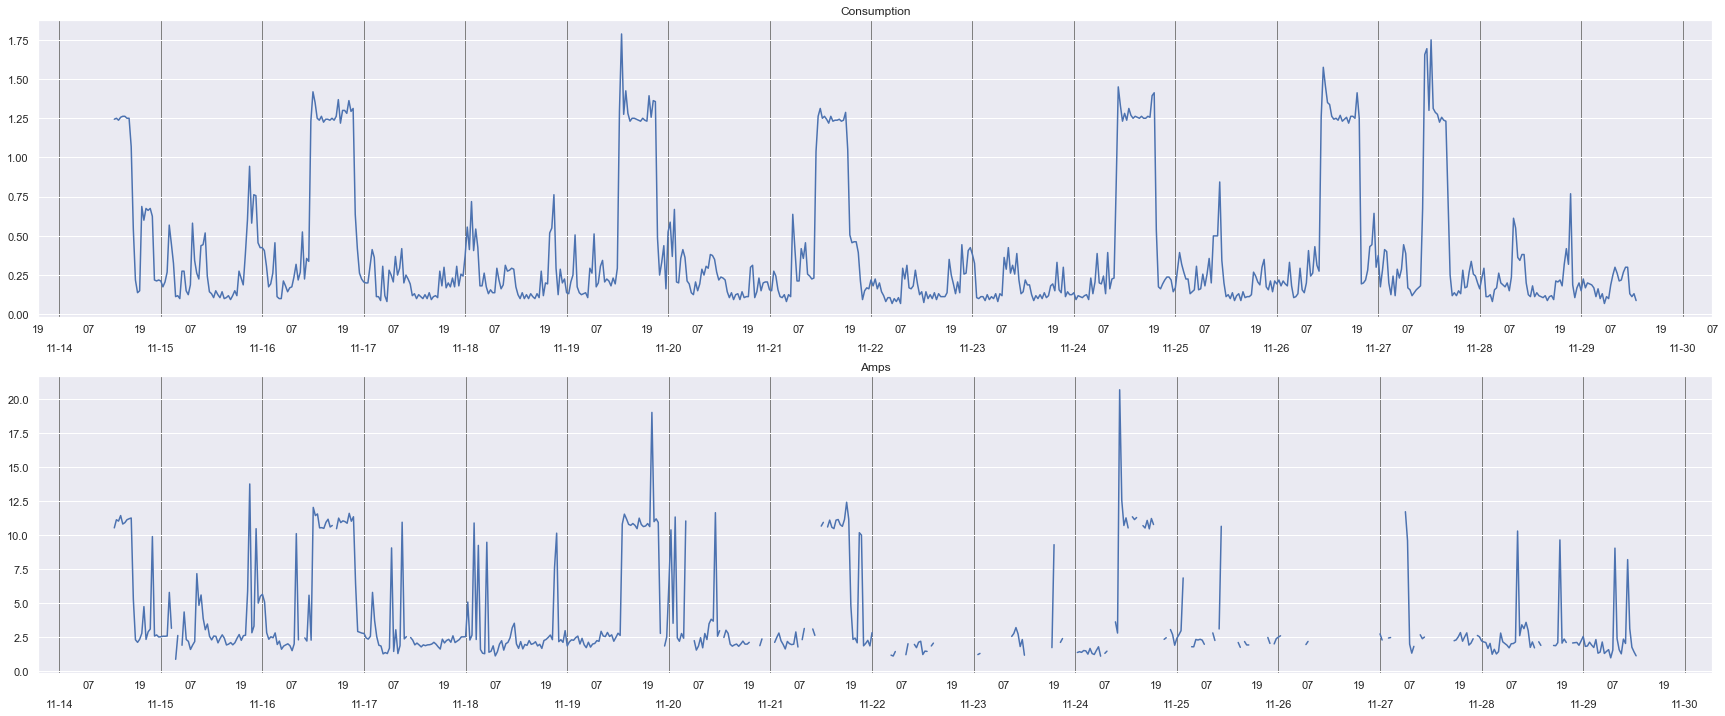

In [97]:
plot_consumption_amps(meters_with_ev[15])


<h3> No EV meters for same period as above </h3>

meter has no EV


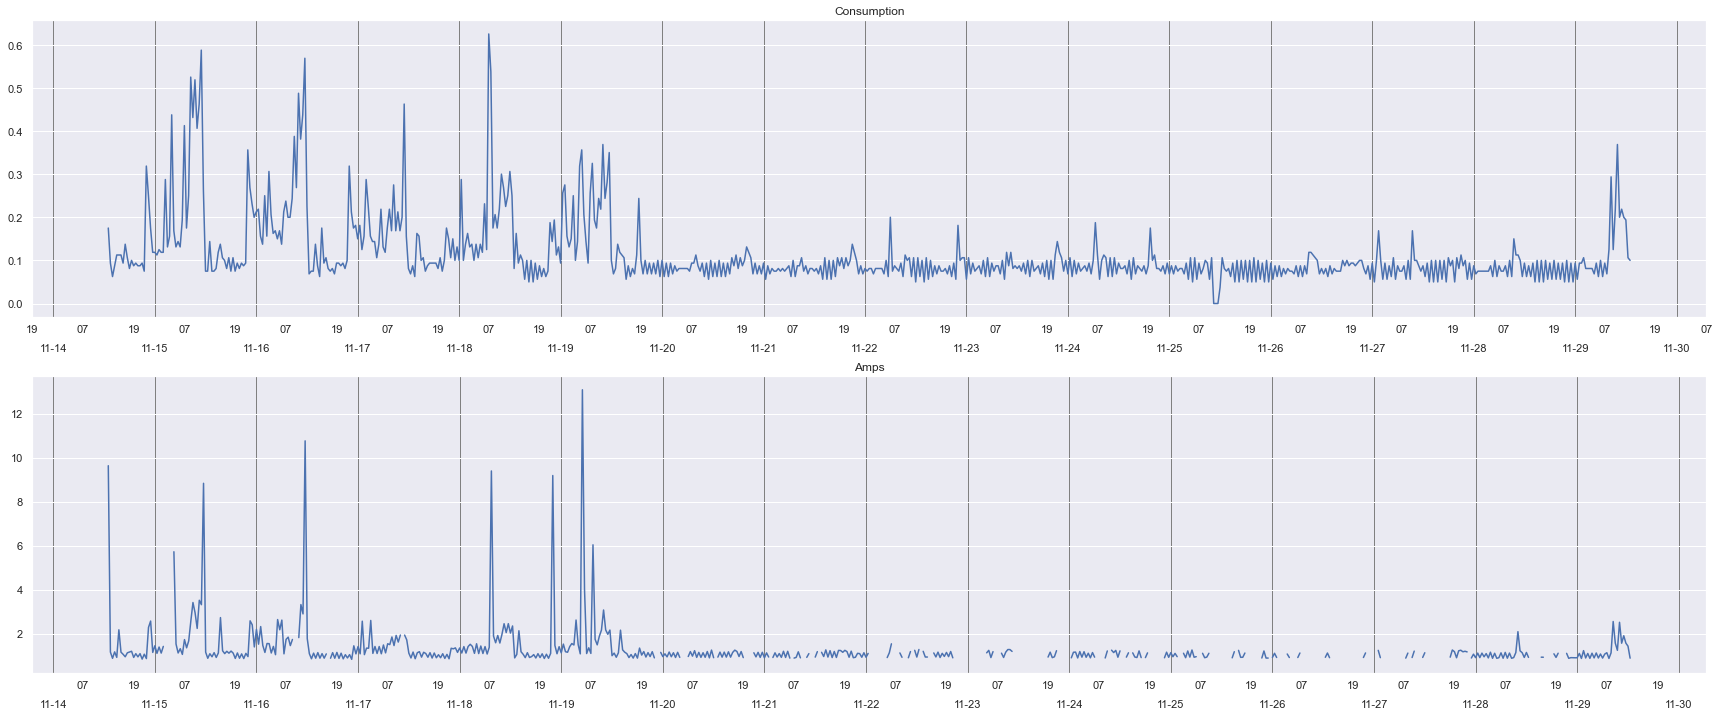

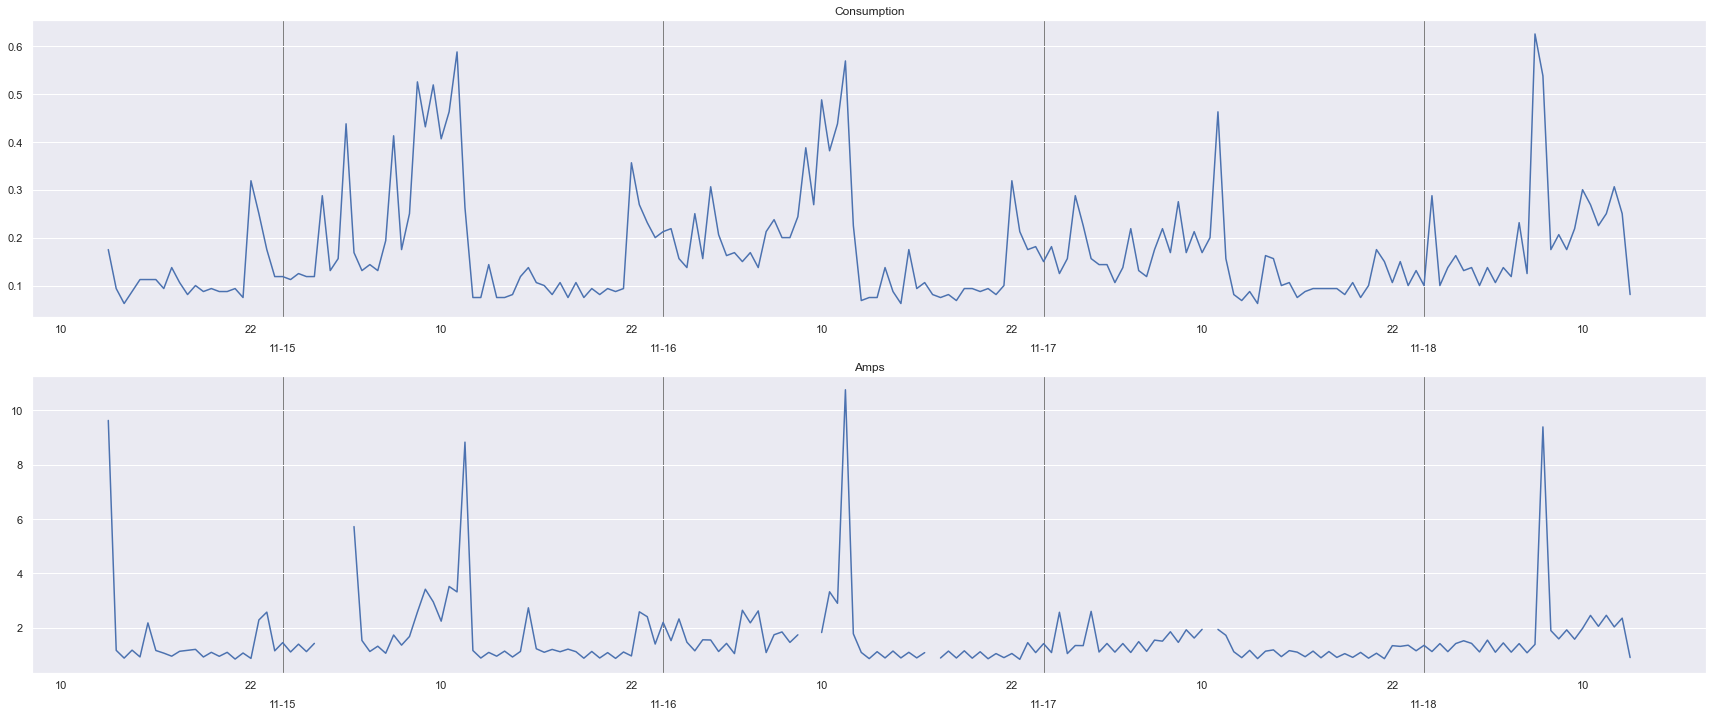

In [98]:
plot_consumption_amps(meters_with_no_ev[0])
plot_consumption_amps(meters_with_no_ev[0], start='2021-11-15', end='2021-11-19', verbose=False)

meter has no EV


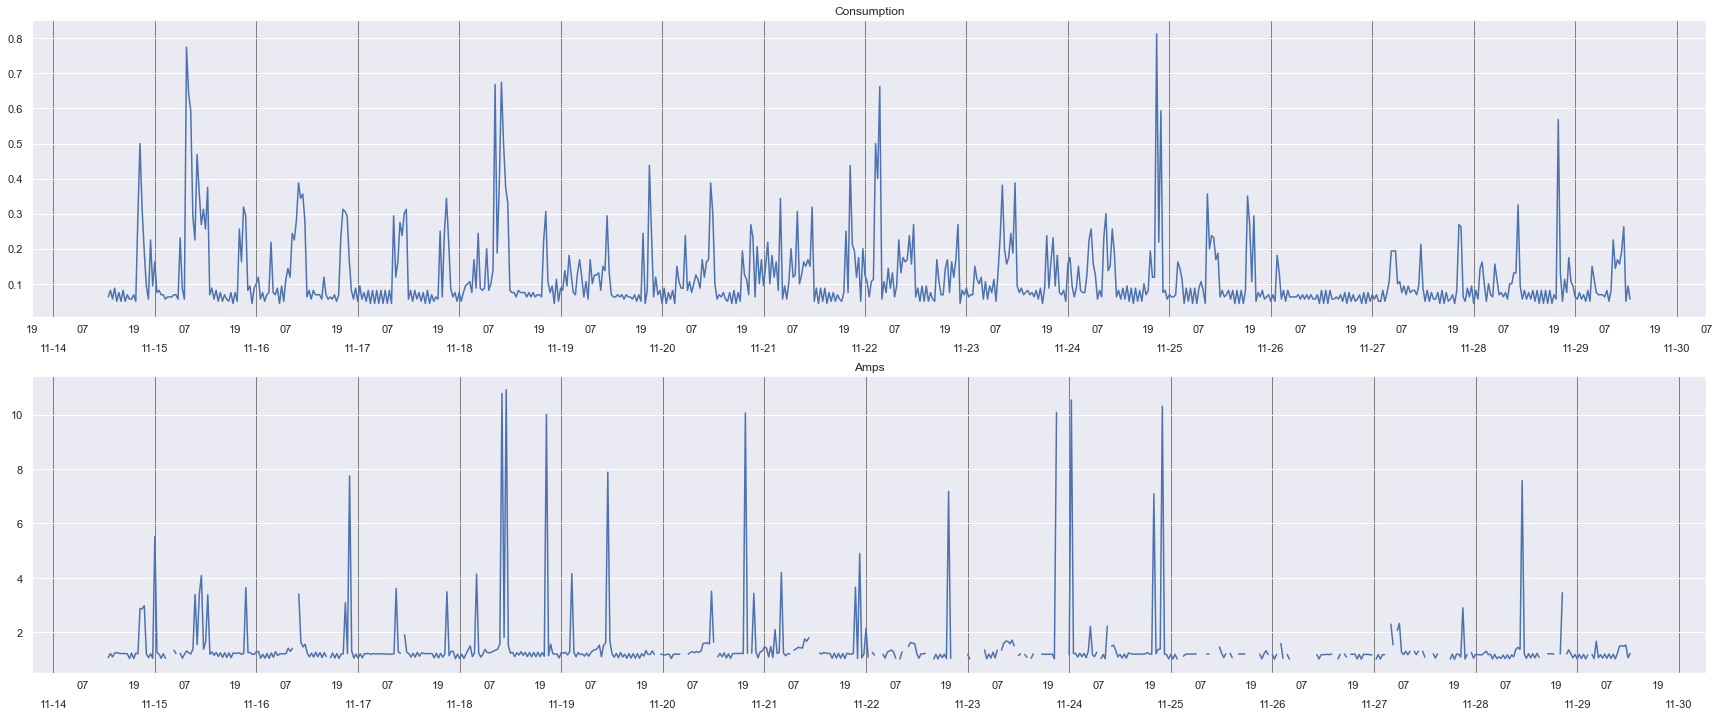

In [99]:
plot_consumption_amps(meters_with_no_ev[1])

meter has no EV


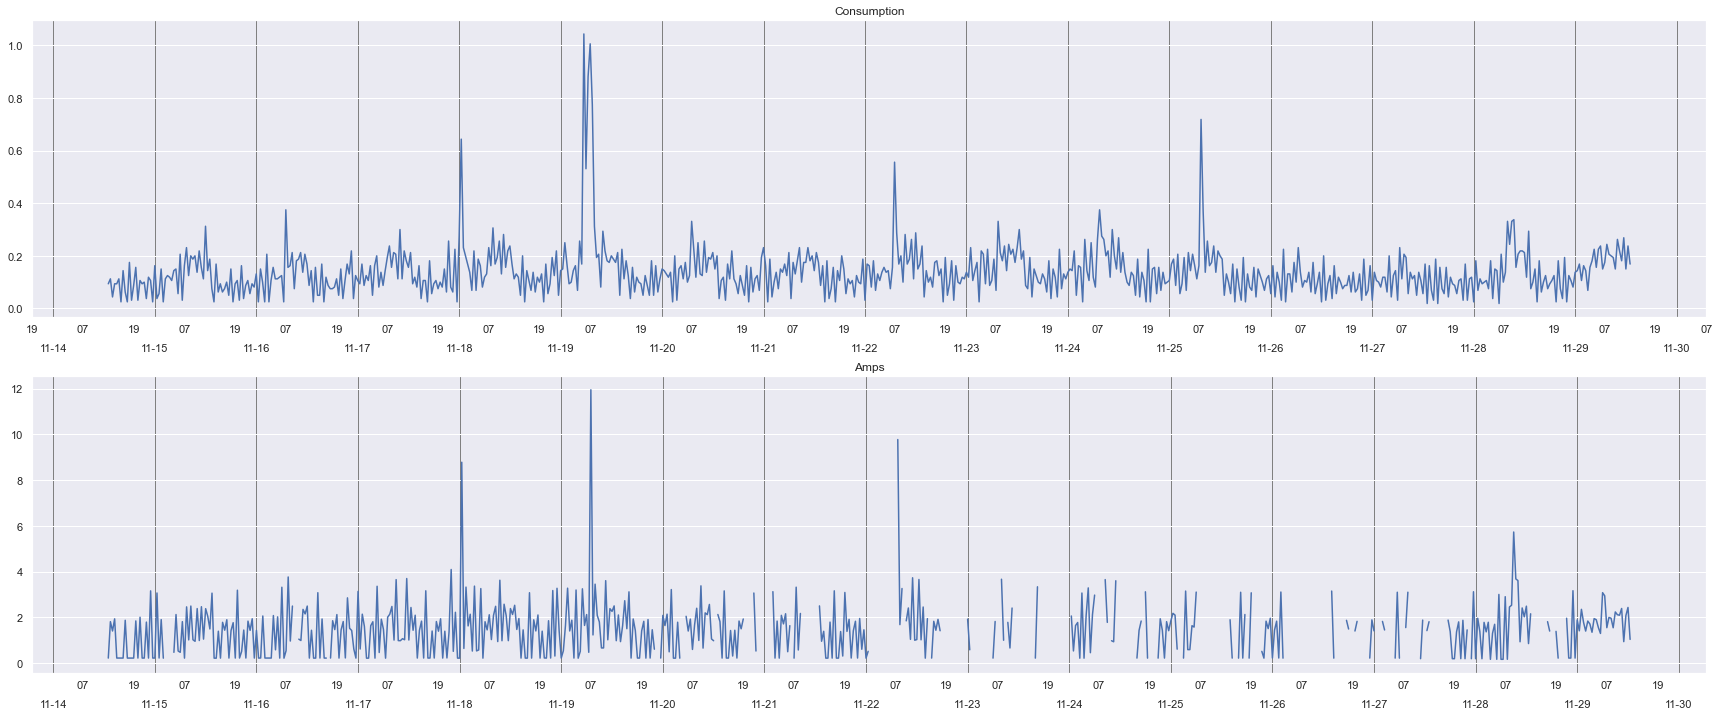

In [100]:
plot_consumption_amps(meters_with_no_ev[2])

meter has no EV


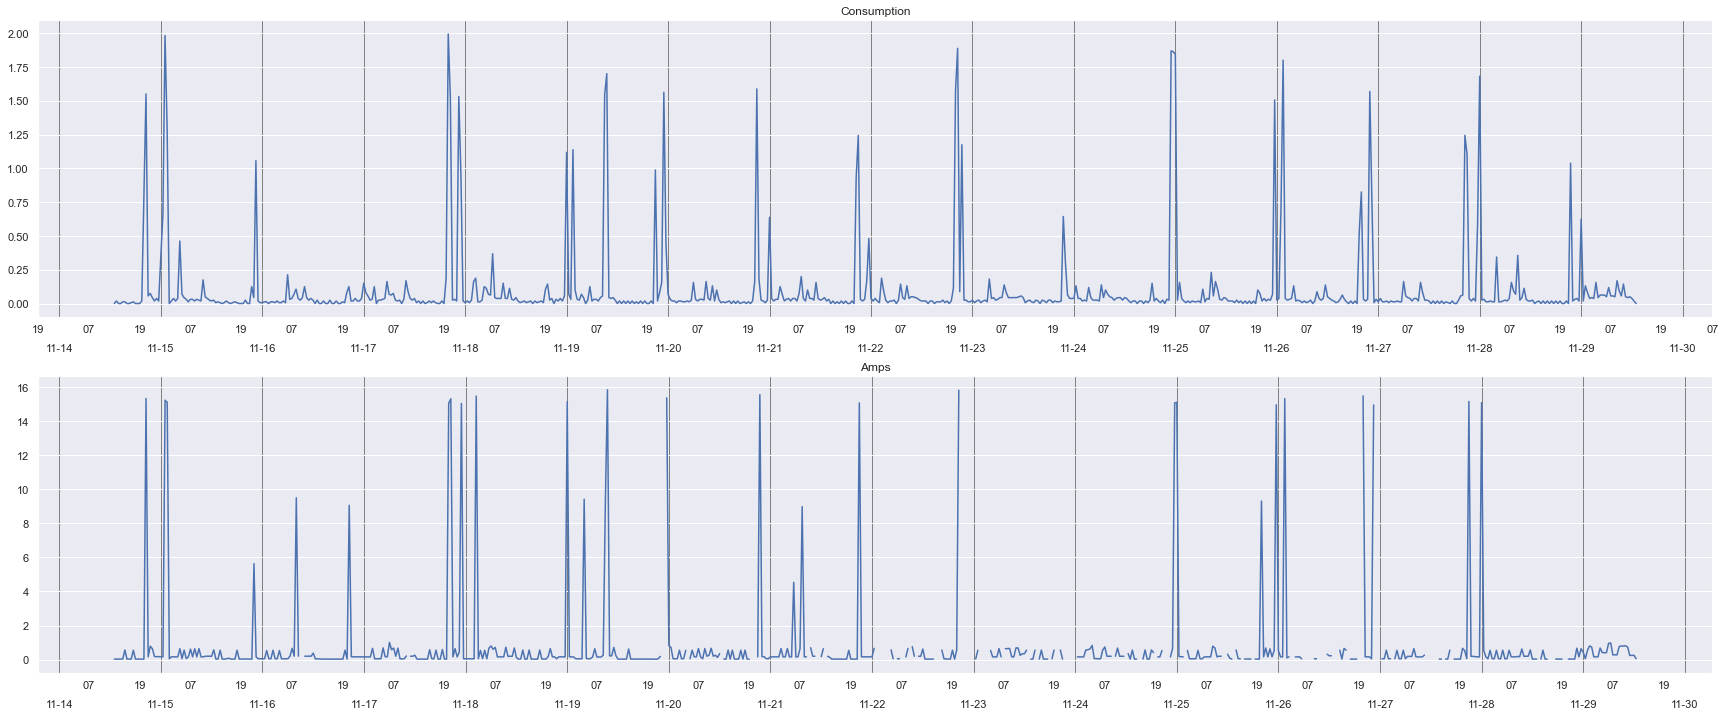

In [101]:
plot_consumption_amps(meters_with_no_ev[3])

meter has no EV


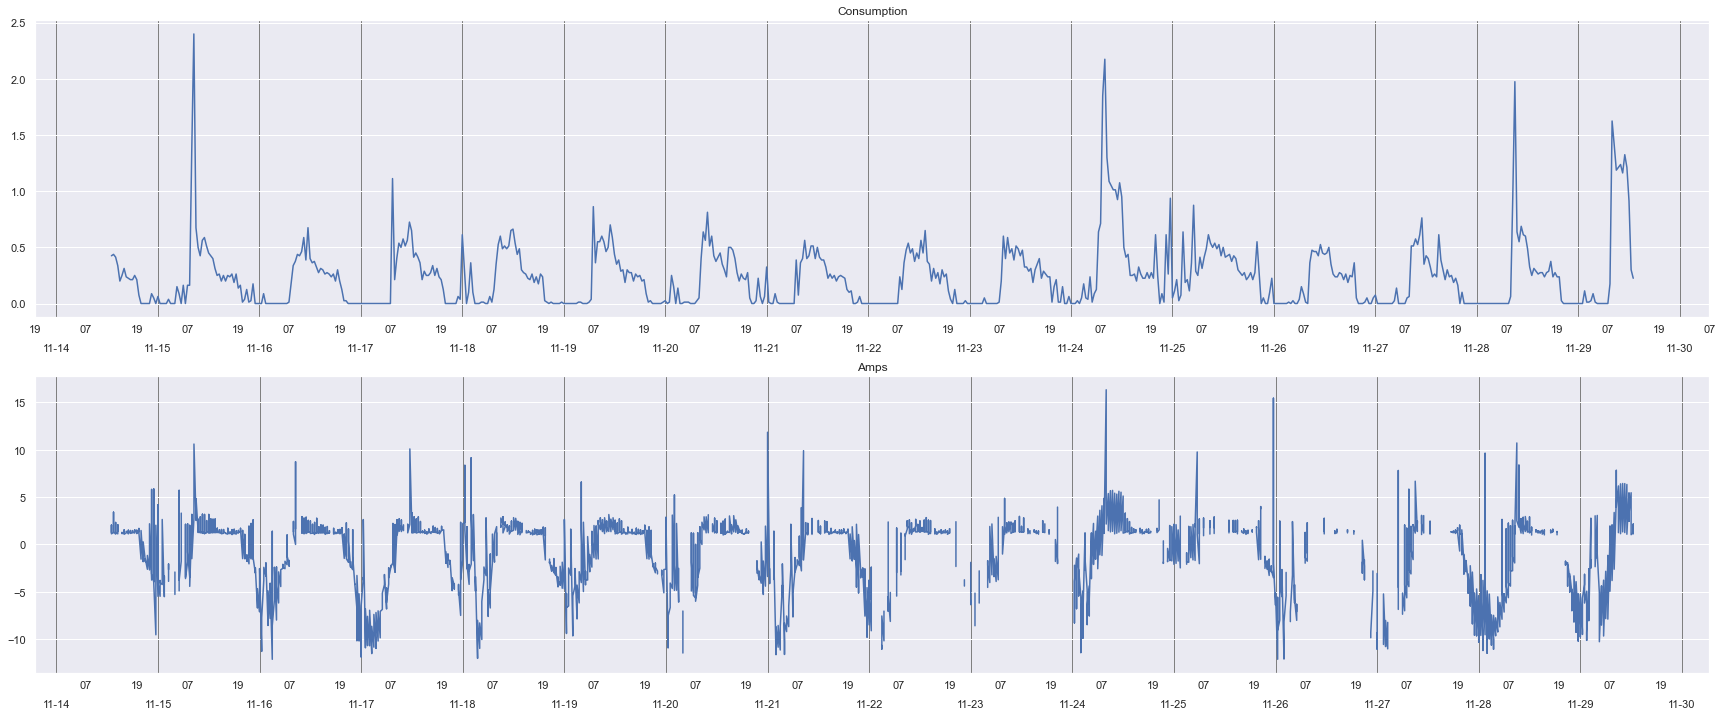

In [102]:
plot_consumption_amps(meters_with_no_ev[4])

meter has no EV


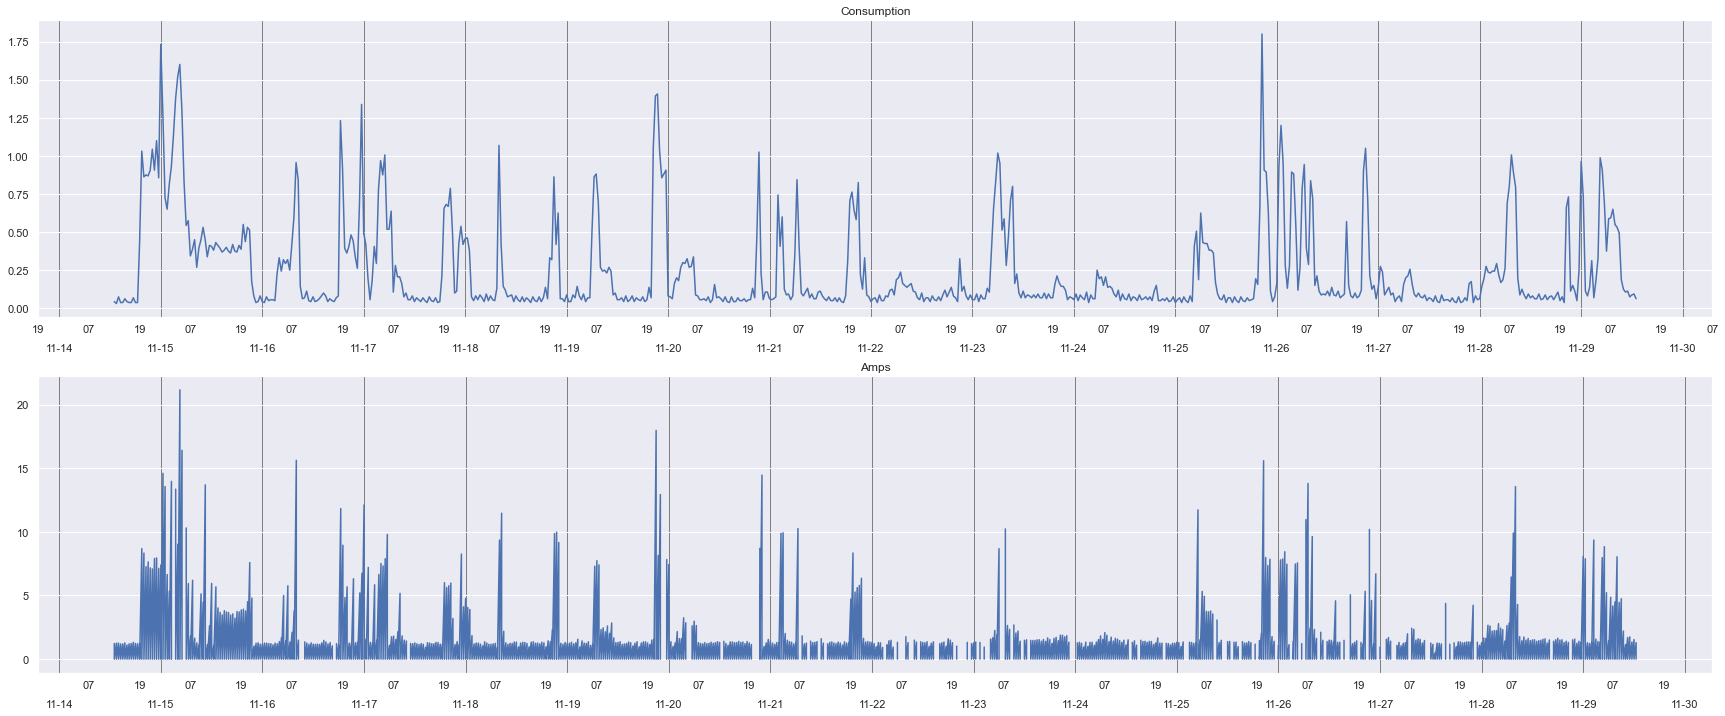

In [103]:
plot_consumption_amps(meters_with_no_ev[5])

meter has no EV


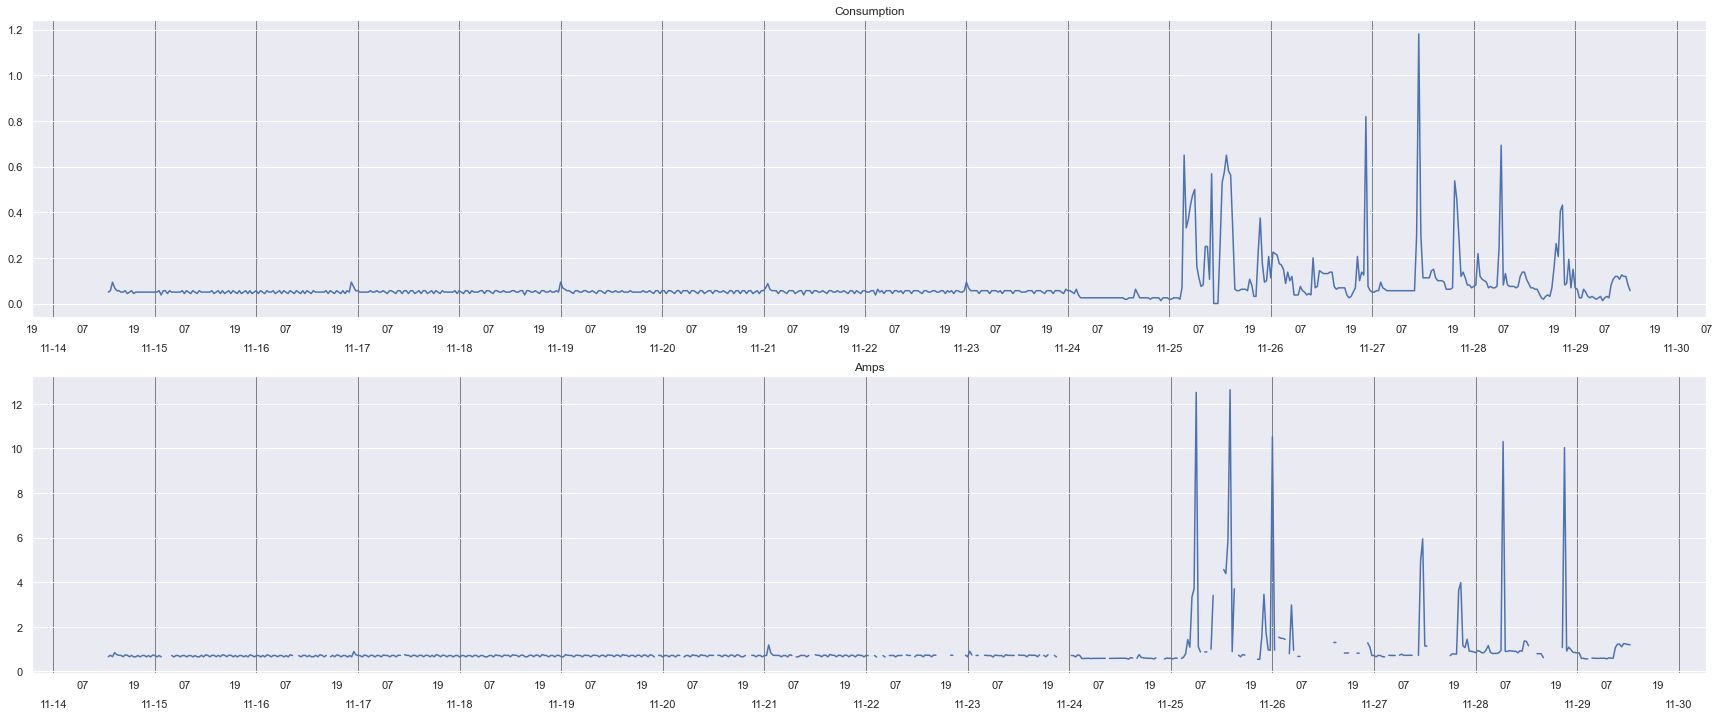

In [104]:

plot_consumption_amps(meters_with_no_ev[7])

In [105]:
plot_consumption_amps(meters_with_no_ev[8])

meter has no EV


In [106]:
plot_consumption_amps(meters_with_no_ev[9])


meter has no EV


meter has no EV


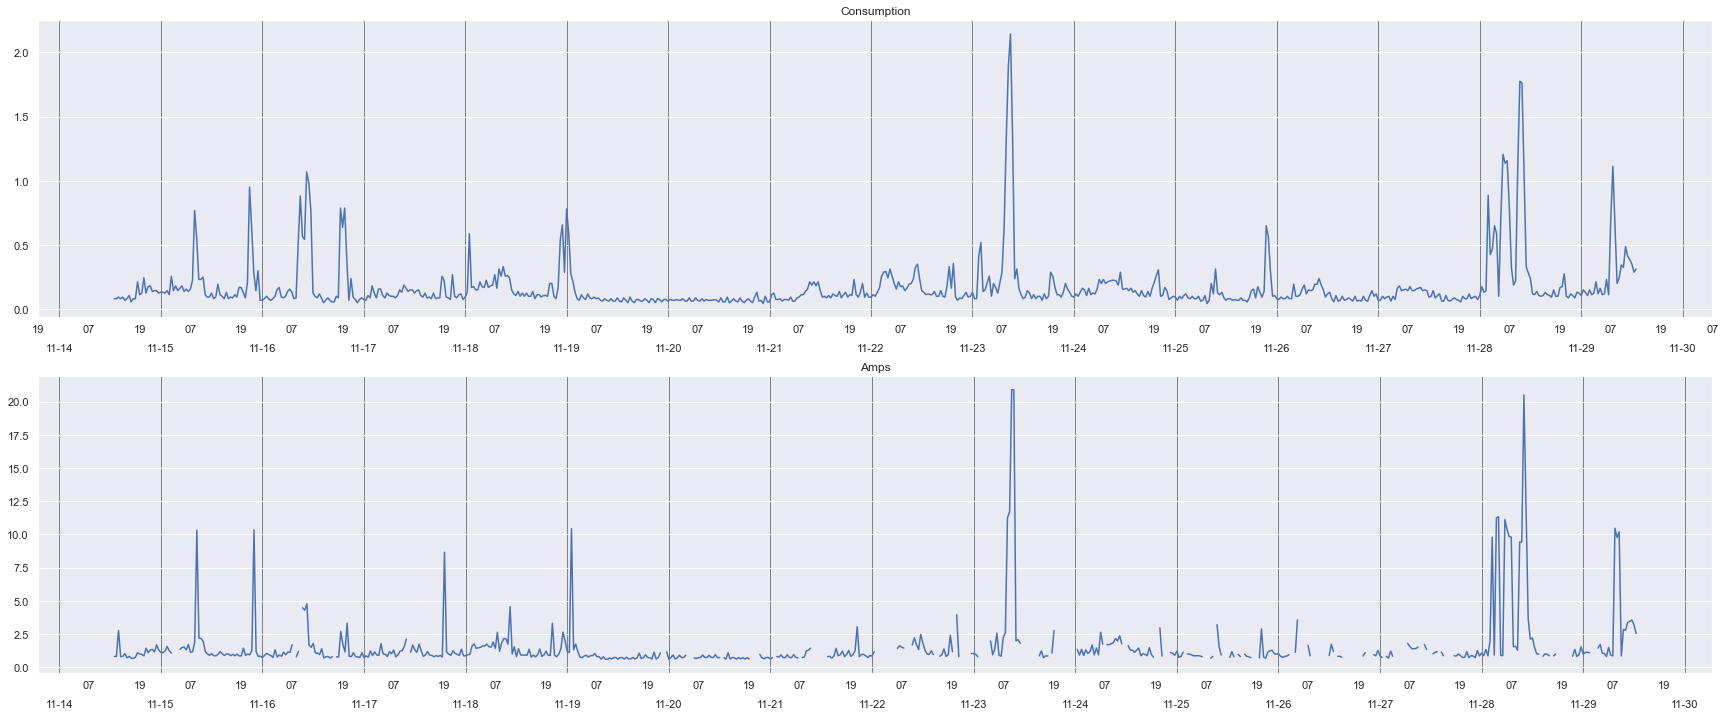

In [107]:
plot_consumption_amps(meters_with_no_ev[10])

In [108]:
plot_consumption_amps(meters_with_no_ev[11])

meter has no EV


meter has no EV


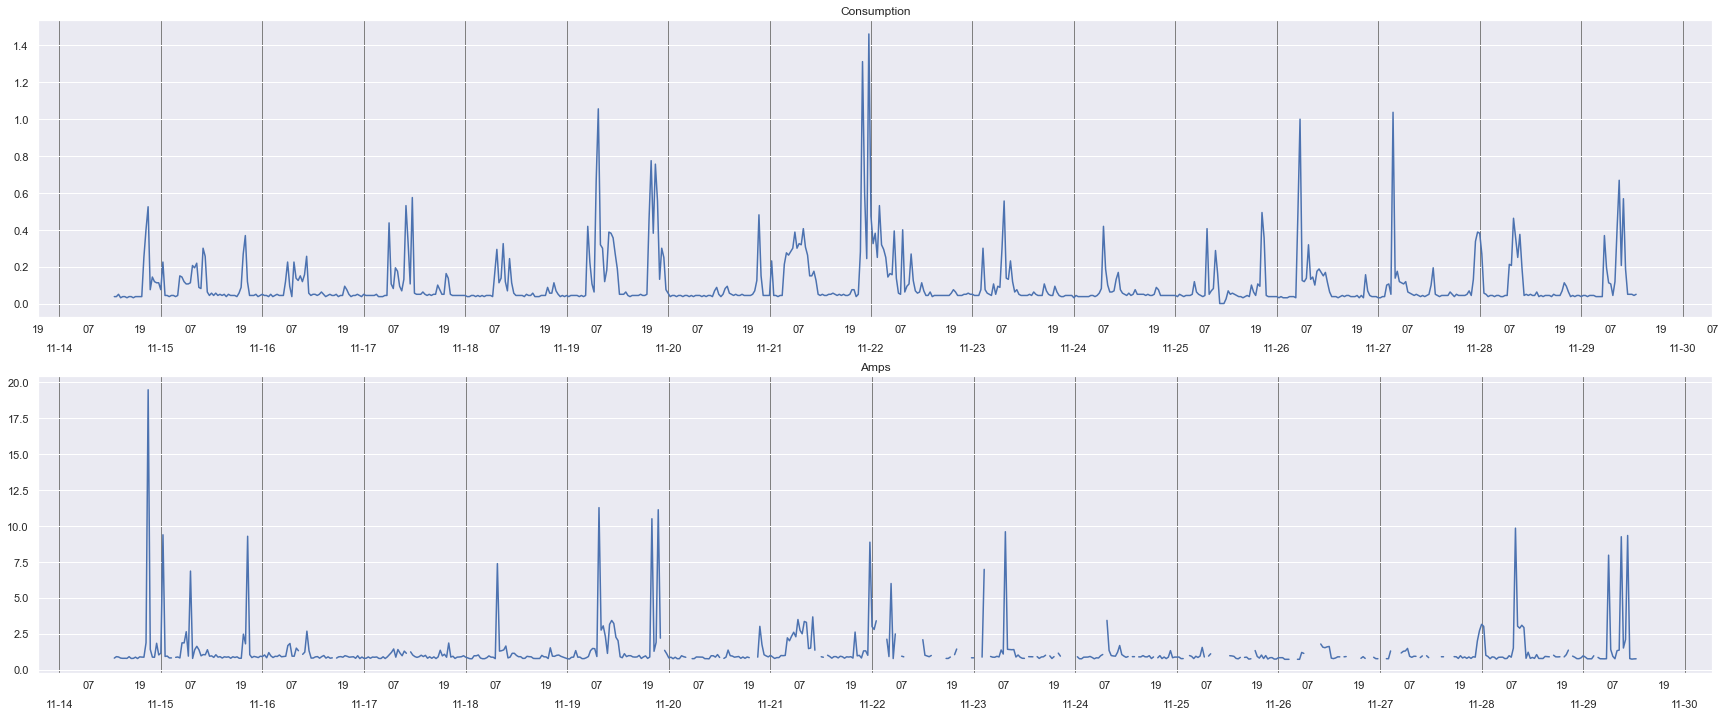

In [109]:
plot_consumption_amps(meters_with_no_ev[12])

meter has no EV
meter has no EV


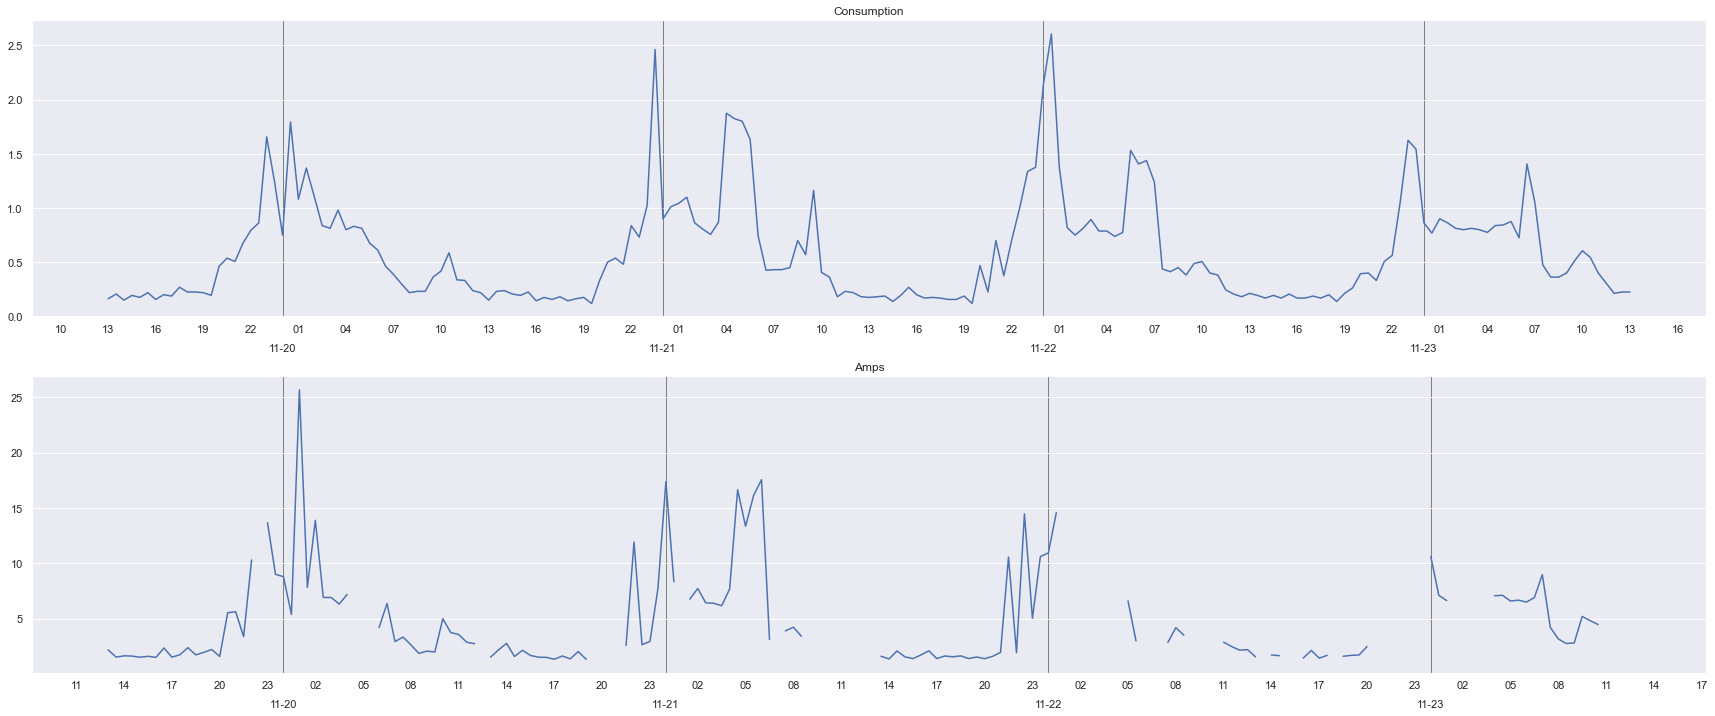

In [110]:
plot_consumption_amps(meters_with_no_ev[13])
plot_consumption_amps(meters_with_no_ev[13], start='2021-11-20', end='2021-11-24', hours_interval=3)

In [111]:
plot_consumption_amps(meters_with_no_ev[14])

meter has no EV


meter has no EV


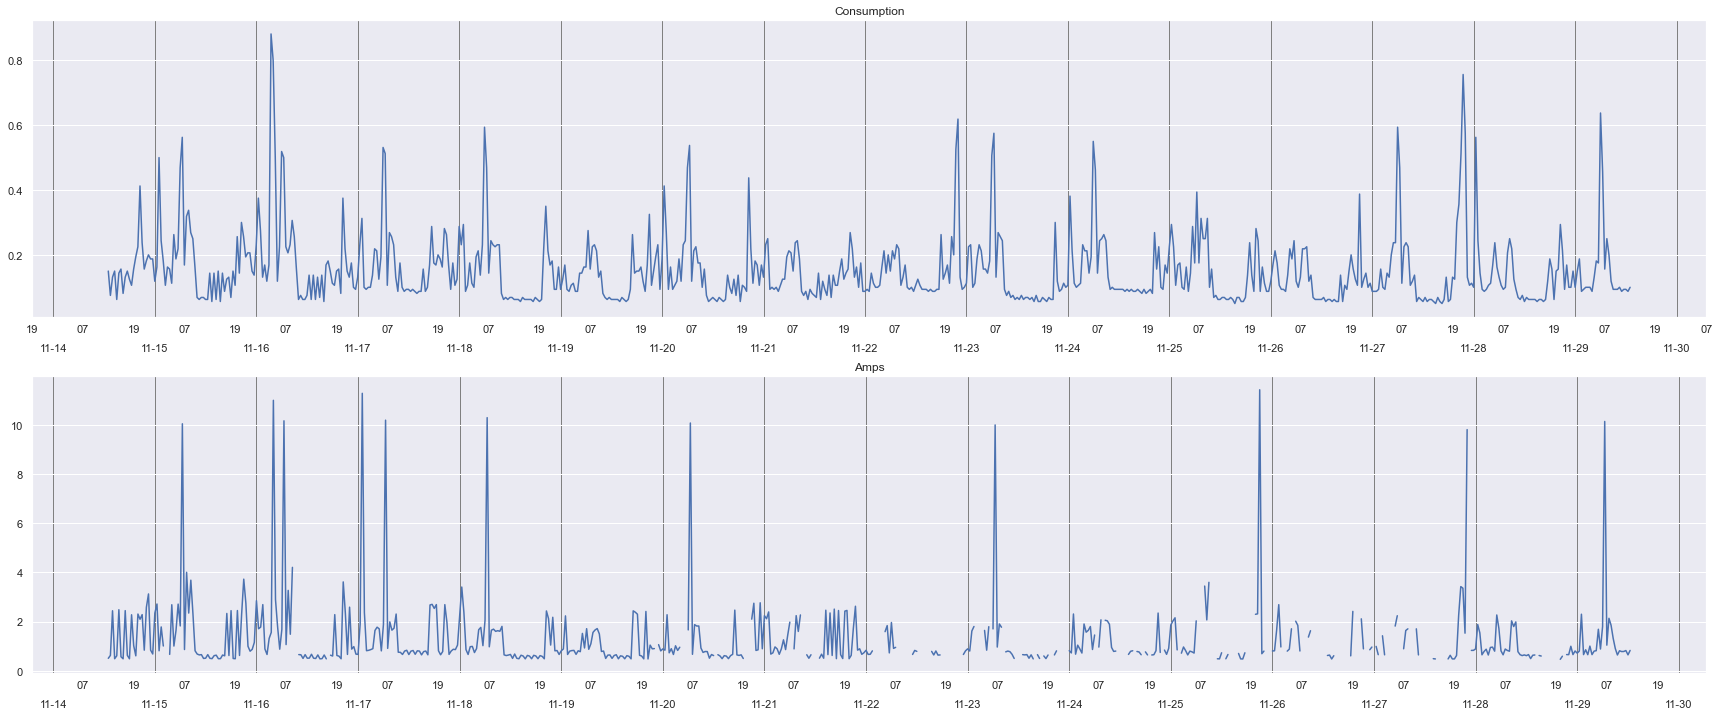

In [112]:
plot_consumption_amps(meters_with_no_ev[15])

<a id='Modelling'></a>

# Modelling

### old approach 

In [ ]:
df_consumption['has_ev'] = np.where(df_consumption['has_ev'].isna(), 0, 1)
# for col in ['year', 'month', 'day', 'hour', 'minute']:
#     df_consumption[col] = getattr(pd.DatetimeIndex(df_consumption['time']), col)
df_consumption_analysis = df_consumption.drop(
    columns=['generation', 'ev_make', 'ev_model', 'wallcharger', 'annual_km', 'annual_km_group',
             'year', 'month', 'day', 'hour', 'minute'])
df_consumption_analysis['identifier'] = df_consumption_analysis['meter'].astype('str') + df_consumption_analysis[
    'element_uuid']
df_consumption_analysis = df_consumption_analysis.drop(columns=['meter', 'element_uuid']).set_index(
    ['identifier', 'time'])
df_consumption_analysis.head()

In [ ]:
import statsmodels.api as sm
from linearmodels import PanelOLS

exog = sm.tools.add_constant(df_consumption_analysis['consumption'])
endog = df_consumption_analysis['has_ev']
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects=True)
fe_res = model_fe.fit()
print(fe_res)

In [ ]:
df_power_quality['has_ev'] = np.where(df_power_quality['has_ev'].isna(), 0, 1)
# for col in ['year', 'month', 'day', 'hour', 'minute']:
#     df_power_quality[col] = getattr(pd.DatetimeIndex(df_power_quality['time']), col)
df_power_quality.drop(
    columns=['overground_or_underground', 'ev_make', 'ev_model', 'wallcharger', 'annual_km', 'annual_km_group'],
    inplace=True)
df_power_quality['identifier'] = df_power_quality['meter'].astype('str') + df_power_quality['channel_cd']
df_power_quality.drop(columns=['meter', 'channel_cs'], inpalce=True)
df_power_quality.set_index(['identifier', 'time'], inplace=True)
df_power_quality.head()

In [ ]:
# import statsmodels.api as sm
# from linearmodels import PanelOLS

# exog = sm.tools.add_constant(df_power_quality['amps'])
# exog = sm.tools.add_constant(df_power_quality['voltage_lvt'])
# exog = sm.tools.add_constant(df_power_quality['power_factor_pf'])
# exog = sm.tools.add_constant(df_power_quality['number_of_phases'])
# endog = df_consumption_analysis['has_ev']
# # fixed effects model
# model_fe = PanelOLS(endog, exog, entity_effects=True)
# fe_res = model_fe.fit()
# print(fe_res)

## Approach one

- Collapsing channels in power quality<br> 
    phase 1: drop channel b<br>
    phase 3: collapse channels; voltage -> mean, amps -> sum, power factor -> mean<br>
- keeping only 30m measurements in power quality
- Collapsing variables to be weekly averages (as features)<br>
- Logistic regression<br>

(note: element_uuid is dropped from consumption)

In [31]:
df_consumption_app01 = df_consumption_for_features.copy().set_index(['meter', 'time'])[['consumption', 'generation', 'total_consumption', 'cons_above_80']]
df_consumption_app01.info()
display('df_consumption_app01.describe().T', f'df_consumption_app01.head()')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1537672 entries, (396, Timestamp('2021-11-01 11:00:00+1100', tz='dateutil/Australia/Melbourne')) to (792189, Timestamp('2021-12-01 10:30:00+1100', tz='dateutil/Australia/Melbourne'))
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   consumption        1537672 non-null  float64
 1   generation         1537672 non-null  float64
 2   total_consumption  1537672 non-null  float64
 3   cons_above_80      1537672 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 47.3 MB


df_consumption_app01.describe().T
                    count    mean     std  min     25%     50%     75%  \
consumption       1537672 0.19558 0.35758    0 0.03120 0.08120 0.20000   
generation        1537672 0.04047 0.24043    0       0       0       0   
total_consumption 1537672 0.23605 0.41330    0 0.04370 0.09370 0.23750   
cons_above_80     1537672 0.19625 0.39716    0       0       0       0   

                       max  
consumption       13.22500  
generation         7.71250  
total_consumption 13.22500  
cons_above_80            1  

df_consumption_app01.head()
                                 consumption  generation  total_consumption  \
meter time                                                                    
396   2021-11-01 11:00:00+11:00      0.04370           0            0.04370   
      2021-11-01 11:30:00+11:00      0.07500           0            0.07500   
      2021-11-01 12:00:00+11:00      0.11870           0            0.11870   
      2021-11-01 12:30:00+11:00      0.05620           0            0.05620   
      2021-11-01 13:00:00+11:00      0.04370           0            0.04370   

                                 cons_above_80  
meter time                                      
396   2021-11-01 11:00:00+11:00              0  
      2021-11-01 11:30:00+11:00              0  
      2021-11-01 12:00:00+11:00              0  
      2021-11-01 12:30:00+11:00              0  
      2021-11-01 13:00:00+11:00              0

In [32]:
df_power_quality_for_features.columns

Index(['meter', 'channel', 'time', 'voltage', 'amps', 'power_factor', 'phases',
       'infrast', 'dayofyear', 'weekofyear', 'dayofweek', 'day', 'month',
       'year', 'weekend', 'abs_power_factor', 'make', 'model', 'charger',
       'drive_kms', 'has_ev', 'amps_above_50', 'amps_above_55',
       'amps_above_60', 'amps_above_65', 'amps_above_70', 'amps_above_75',
       'amps_above_80', 'amps_above_85', 'amps_above_90', 'amps_above_95'],
      dtype='object')

In [33]:
df_power_quality_app01 = df_power_quality_for_features.copy()
df_power_quality_app01 = df_power_quality_app01.query("phases == 3 | channel == 'a'")\
    .groupby(['meter', 'time'])\
        .aggregate({
            'amps': 'sum',
            'voltage': 'mean',
            'abs_power_factor': 'mean',
            'phases': 'first',
            'has_ev': 'first',
            'weekofyear': 'first',
            'weekend': 'first',
            'amps_above_80': 'first'
        })
df_power_quality_app01.info()
display('df_power_quality_app01.describe().T', f'df_power_quality_app01.head()')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8067436 entries, (396, Timestamp('2021-11-01 00:00:00+1100', tz='dateutil/Australia/Melbourne')) to (792189, Timestamp('2021-11-29 23:55:00+1100', tz='dateutil/Australia/Melbourne'))
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   amps              float64
 1   voltage           float64
 2   abs_power_factor  float64
 3   phases            int64  
 4   has_ev            int32  
 5   weekofyear        int64  
 6   weekend           int32  
 7   amps_above_80     int32  
dtypes: float64(3), int32(3), int64(2)
memory usage: 446.8 MB


df_power_quality_app01.describe().T
                   count      mean     std       min       25%       50%  \
amps             8067436   1.56732 4.19876 -73.42710   0.42857   0.94378   
voltage          8067436 238.86128 9.54156         0 236.20000 240.11000   
abs_power_factor 8067436   0.75468 0.26587   0.00067   0.59000   0.85800   
phases           8067436   1.14350 0.51615         1         1         1   
has_ev           8067436   0.06017 0.23780         0         0         0   
weekofyear       8067436  45.47379 1.16263        44        44        45   
weekend          8067436   0.27291 0.44546         0         0         0   
amps_above_80    8067436   0.23234 0.42232         0         0         0   

                       75%       max  
amps               1.78178 152.17240  
voltage          243.20000 259.99000  
abs_power_factor   0.98300         1  
phases                   1         3  
has_ev                   0         1  
weekofyear              46        48  
weekend                  1         1  
amps_above_80            0         1  

df_power_quality_app01.head()
                                   amps   voltage  abs_power_factor  phases  \
meter time                                                                    
396   2021-11-01 00:00:00+11:00 0.34400 242.47000                 1       1   
      2021-11-01 00:05:00+11:00 0.33518 244.95000           0.54300       1   
      2021-11-01 00:10:00+11:00 0.33152 243.59000           0.55200       1   
      2021-11-01 00:15:00+11:00 0.56629 244.58000           0.97300       1   
      2021-11-01 00:20:00+11:00 0.54029 245.43000           0.96800       1   

                                 has_ev  weekofyear  weekend  amps_above_80  
meter time                                                                   
396   2021-11-01 00:00:00+11:00       0          44        0              0  
      2021-11-01 00:05:00+11:00       0          44        0              0  
      2021-11-01 00:10:00+11:00       0          44        0              0  
      2021-11-01 00:15:00+11:00       0          44        0              0  
      2021-11-01 00:20:00+11:00       0          44        0              0

In [41]:

list(map(len, df_merged_app01.reset_index().groupby('has_ev')['meter'].unique()))

[993, 49]

In [40]:
# merging consumption with power quality
df_merged_app01 = pd.merge(left=df_consumption_app01, right=df_power_quality_app01, left_index=True, right_index=True, validate="one_to_one")
df_merged_app01.info()
display('df_merged_app01.describe().T', f'df_merged_app01.head()')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1269812 entries, (396, Timestamp('2021-11-01 11:00:00+1100', tz='dateutil/Australia/Melbourne')) to (792189, Timestamp('2021-11-29 23:30:00+1100', tz='dateutil/Australia/Melbourne'))
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   consumption        1269812 non-null  float64
 1   generation         1269812 non-null  float64
 2   total_consumption  1269812 non-null  float64
 3   cons_above_80      1269812 non-null  int32  
 4   amps               1269812 non-null  float64
 5   voltage            1269812 non-null  float64
 6   abs_power_factor   1269812 non-null  float64
 7   phases             1269812 non-null  int64  
 8   has_ev             1269812 non-null  int32  
 9   weekofyear         1269812 non-null  int64  
 10  weekend            1269812 non-null  int32  
 11  amps_above_80      1269812 non-null  int32  
dtypes: float64(6), int32(4), int6

df_merged_app01.describe().T
                    count      mean     std       min       25%       50%  \
consumption       1269812   0.18822 0.33890         0   0.03120   0.08120   
generation        1269812   0.03489 0.22457         0         0         0   
total_consumption 1269812   0.22311 0.39101         0   0.03750   0.09370   
cons_above_80     1269812   0.18996 0.39227         0         0         0   
amps              1269812   1.51672 3.99796 -70.71837   0.42215   0.92637   
voltage           1269812 238.80283 9.61132 117.03550 236.19000 240.09000   
abs_power_factor  1269812   0.75393 0.26622   0.00100   0.58822   0.85700   
phases            1269812   1.12191 0.47849         1         1         1   
has_ev            1269812   0.03581 0.18582         0         0         0   
weekofyear        1269812  45.49585 1.15604        44        44        45   
weekend           1269812   0.27753 0.44778         0         0         0   
amps_above_80     1269812   0.22891 0.42013         0         0         0   

                        75%       max  
consumption         0.19370  13.22500  
generation                0   7.71250  
total_consumption   0.22500  13.22500  
cons_above_80             0         1  
amps                1.72509 146.54390  
voltage           243.14000 258.19000  
abs_power_factor    0.98300         1  
phases                    1         3  
has_ev                    0         1  
weekofyear               46        48  
weekend                   1         1  
amps_above_80             0         1  

df_merged_app01.head()
                                 consumption  generation  total_consumption  \
meter time                                                                    
396   2021-11-01 11:00:00+11:00      0.04370           0            0.04370   
      2021-11-01 11:30:00+11:00      0.07500           0            0.07500   
      2021-11-01 12:00:00+11:00      0.11870           0            0.11870   
      2021-11-01 12:30:00+11:00      0.05620           0            0.05620   
      2021-11-01 13:00:00+11:00      0.04370           0            0.04370   

                                 cons_above_80    amps   voltage  \
meter time                                                         
396   2021-11-01 11:00:00+11:00              0 0.57332 249.83000   
      2021-11-01 11:30:00+11:00              0 0.56925 250.09000   
      2021-11-01 12:00:00+11:00              0 0.58291 247.35000   
      2021-11-01 12:30:00+11:00              0 0.69596 249.14000   
      2021-11-01 13:00:00+11:00              0 0.31250       247   

                                 abs_power_factor  phases  has_ev  weekofyear  \
meter time                                                                      
396   2021-11-01 11:00:00+11:00           0.98200       1       0          44   
      2021-11-01 11:30:00+11:00           0.98200       1       0          44   
      2021-11-01 12:00:00+11:00           0.98300       1       0          44   
      2021-11-01 12:30:00+11:00           0.99000       1       0          44   
      2021-11-01 13:00:00+11:00           0.57600       1       0          44   

                                 weekend  amps_above_80  
meter time                                               
396   2021-11-01 11:00:00+11:00        0              0  
      2021-11-01 11:30:00+11:00        0              0  
      2021-11-01 12:00:00+11:00        0              0  
      2021-11-01 12:30:00+11:00        0              0  
      2021-11-01 13:00:00+11:00        0              0

In [32]:
df_temp.head()

consumption_mean  consumption_std  \
meter weekend time                                                           
396   0       2021-11-07 00:00:00+11:00           0.07945          0.04658   
              2021-11-14 00:00:00+11:00           0.12802          0.13550   
              2021-11-21 00:00:00+11:00           0.09839          0.06392   
              2021-11-28 00:00:00+11:00           0.08342          0.07032   
      1       2021-11-07 00:00:00+11:00           0.09597          0.07884   

                                         total_consumption_times_pf_mean  \
meter weekend time                                                         
396   0       2021-11-07 00:00:00+11:00                          0.06998   
              2021-11-14 00:00:00+11:00                          0.11140   
              2021-11-21 00:00:00+11:00                          0.08367   
              2021-11-28 00:00:00+11:00                          0.07411   
      1       2021-11-07 00:00:00+11:00                          0.08471   

                                         total_consumption_times_pf_std  \
meter weekend time                                                        
396   0       2021-11-07 00:00:00+11:00                         0.04635   
              2021-11-14 00:00:00+11:00                         0.12406   
              2021-11-21 00:00:00+11:00                         0.05729   
              2021-11-28 00:00:00+11:00                         0.06752   
      1       2021-11-07 00:00:00+11:00                         0.07133   

                                         amps_mean  amps_std  \
meter weekend time                                             
396   0       2021-11-07 00:00:00+11:00    0.73387   0.86842   
              2021-11-14 00:00:00+11:00    1.18463   1.36059   
              2021-11-21 00:00:00+11:00    0.95163   0.95444   
              2021-11-28 00:00:00+11:00    0.78815   0.88368   
      1       2021-11-07 00:00:00+11:00    0.85838   1.09029   

                                         abs_power_factor_mean  phases_first  \
meter weekend time                                                             
396   0       2021-11-07 00:00:00+11:00                0.85307             1   
              2021-11-14 00:00:00+11:00                0.84020             1   
              2021-11-21 00:00:00+11:00                0.83104             1   
              2021-11-28 00:00:00+11:00                0.85587             1   
      1       2021-11-07 00:00:00+11:00                0.86053             1   

                                         has_ev_first  consumption_coeff_var  
meter weekend time                                                            
396   0       2021-11-07 00:00:00+11:00             0                1.70566  
              2021-11-14 00:00:00+11:00             0                0.94481  
              2021-11-21 00:00:00+11:00             0                1.53913  
              2021-11-28 00:00:00+11:00             0                1.18624  
      1       2021-11-07 00:00:00+11:00             0                1.21722

In [ ]:
df_temp = df_merged_app01.reset_index(level='meter').groupby(['meter']).resample('W').aggregate({
    'consumption': ['mean', 'std'],
    'total_consumption_times_pf': ['mean', 'std'],
    'amps': ['mean', 'std'],
    'abs_power_factor': 'mean',
    'phases': 'first',
    'has_ev': 'first',
    'weekofyear': 'first',
    'cons_above_80': 'sum',
    'amps_above_80': 'sum'
})
df_temp.columns = ['_'.join(name) for name in df_temp.columns.to_flat_index() if name[-1]]
df_temp['consumption_coeff_var'] = df_temp['consumption_mean'] / df_temp['consumption_std']
df_temp['amps_coeff_var'] = df_temp['amps_mean'] / df_temp['amps_std']
df_temp['total_consumption_coeff_var'] = df_temp['total_consumption_times_pf_mean'] / df_temp['total_consumption_times_pf_std']

# df_merged_app01.head()
df_temp.head()

consumption_mean  consumption_std  \
meter time                                                           
396   2021-11-07 00:00:00+11:00           0.08440          0.05851   
      2021-11-14 00:00:00+11:00           0.13626          0.13394   
      2021-11-21 00:00:00+11:00           0.09339          0.05941   
      2021-11-28 00:00:00+11:00           0.08601          0.06954   
428   2021-11-07 00:00:00+11:00           0.08273          0.23305   

                                 total_consumption_times_pf_mean  \
meter time                                                         
396   2021-11-07 00:00:00+11:00                          0.07439   
      2021-11-14 00:00:00+11:00                          0.11887   
      2021-11-21 00:00:00+11:00                          0.07952   
      2021-11-28 00:00:00+11:00                          0.07527   
428   2021-11-07 00:00:00+11:00                          0.08149   

                                 total_consumption_times_pf_std  amps_mean  \
meter time                                                                   
396   2021-11-07 00:00:00+11:00                         0.05533    0.77119   
      2021-11-14 00:00:00+11:00                         0.12521    1.31371   
      2021-11-21 00:00:00+11:00                         0.05399    0.92126   
      2021-11-28 00:00:00+11:00                         0.06608    0.83028   
428   2021-11-07 00:00:00+11:00                         0.23094    0.71722   

                                 amps_std  abs_power_factor_mean  \
meter time                                                         
396   2021-11-07 00:00:00+11:00   0.94032                0.85531   
      2021-11-14 00:00:00+11:00   1.58921                0.83665   
      2021-11-21 00:00:00+11:00   0.99655                0.82997   
      2021-11-28 00:00:00+11:00   0.97772                0.85009   
428   2021-11-07 00:00:00+11:00   2.42662                0.97631   

                                 phases_first  has_ev_first  weekofyear_first  \
meter time                                                                      
396   2021-11-07 00:00:00+11:00             1             0                44   
      2021-11-14 00:00:00+11:00             1             0                45   
      2021-11-21 00:00:00+11:00             1             0                46   
      2021-11-28 00:00:00+11:00             1             0                47   
428   2021-11-07 00:00:00+11:00             1             0                44   

                                 cons_above_80_sum  amps_above_80_sum  \
meter time                                                              
396   2021-11-07 00:00:00+11:00                  6                 14   
      2021-11-14 00:00:00+11:00                 30                 87   
      2021-11-21 00:00:00+11:00                  2                 53   
      2021-11-28 00:00:00+11:00                  4                 21   
428   2021-11-07 00:00:00+11:00                 15                  9   

                                 consumption_coeff_var  amps_coeff_var  \
meter time                                                               
396   2021-11-07 00:00:00+11:00                1.44250         0.82014   
      2021-11-14 00:00:00+11:00                1.01730         0.82664   
      2021-11-21 00:00:00+11:00                1.57182         0.92445   
      2021-11-28 00:00:00+11:00                1.23694         0.84920   
428   2021-11-07 00:00:00+11:00                0.35497         0.29556   

                                 total_consumption_coeff_var  
meter time                                                    
396   2021-11-07 00:00:00+11:00                      1.34450  
      2021-11-14 00:00:00+11:00                      0.94939  
      2021-11-21 00:00:00+11:00                      1.47265  
      2021-11-28 00:00:00+11:00                      1.13918  
428   2021-11-07 00:00:00+11:00                      0.35284

In [ ]:
df_temp = df_temp.unstack()
df_temp.columns = ['_'.join(map(lambda x: str(x), name)) for name in df_temp.columns.to_flat_index() if name[-1]]
drop_first_from_col = lambda x: x.replace('_first', '').replace(' 00:00:00+11:00', '')
rename_those_starting_with_cons = lambda x: f'raw_{x}' if x.startswith('consumption') else x
df_temp = df_temp.rename(drop_first_from_col, axis=1)
df_temp = df_temp.rename(rename_those_starting_with_cons, axis=1)
df_temp.head()

raw_consumption_mean_2021-11-07  raw_consumption_mean_2021-11-14  \
meter                                                                     
396                            0.08440                          0.13626   
428                            0.08273                          0.08926   
829                            0.25499                          0.45169   
4970                           0.09973                          0.09238   
5228                           0.17416                                0   

       raw_consumption_mean_2021-11-21  raw_consumption_mean_2021-11-28  \
meter                                                                     
396                            0.09339                          0.08601   
428                            0.10899                          0.08270   
829                            0.39161                          0.26923   
4970                           0.08560                          0.08735   
5228                           0.04044                                0   

       raw_consumption_mean_2021-12-05  raw_consumption_std_2021-11-07  \
meter                                                                    
396                                NaN                         0.05851   
428                            0.09770                         0.23305   
829                            0.42168                         0.29887   
4970                           0.05853                         0.24981   
5228                           0.05078                         0.24955   

       raw_consumption_std_2021-11-14  raw_consumption_std_2021-11-21  \
meter                                                                   
396                           0.13394                         0.05941   
428                           0.25461                         0.27078   
829                           0.57099                         0.51162   
4970                          0.22151                         0.22107   
5228                                0                         0.11938   

       raw_consumption_std_2021-11-28  raw_consumption_std_2021-12-05  ...  \
meter                                                                  ...   
396                           0.06954                             NaN  ...   
428                           0.21554                         0.22774  ...   
829                           0.29434                         0.41679  ...   
4970                          0.22329                         0.12701  ...   
5228                                0                         0.03905  ...   

       amps_coeff_var_2021-11-07  amps_coeff_var_2021-11-14  \
meter                                                         
396                      0.82014                    0.82664   
428                      0.29556                    0.29207   
829                      0.68415                    0.71021   
4970                     0.99786                    1.04074   
5228                     0.80083                    0.68262   

       amps_coeff_var_2021-11-21  amps_coeff_var_2021-11-28  \
meter                                                         
396                      0.92445                    0.84920   
428                      0.33128                    0.30239   
829                      0.68173                    0.67489   
4970                     1.28863                    1.16494   
5228                     0.51201                    0.61773   

       amps_coeff_var_2021-12-05  total_consumption_coeff_var_2021-11-07  \
meter                                                                      
396                          NaN                                 1.34450   
428                      0.32169                                 0.35284   
829                      0.88872                                 0.81032   
4970                    25.66716                                 0.23865   
5228                     1.24538     

In [97]:
# total consumption per week (coefficiet of variance)
X1 = [x for x in df_temp.columns.to_list() if 'total_consumption_coeff_var' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
# total consumption per week (mean and standard deviation)
X2 = [x for x in df_temp.columns.to_list() if 'total_consumption_mean' in x or 'total_consumption_std' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
# raw consumption per week (coefficiet of variance)
X3 = [x for x in df_temp.columns.to_list() if 'raw_consumption_coeff_var' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
# raw consumption per week (mean and standard deviation)
X4 = [x for x in df_temp.columns.to_list() if 'raw_consumption_mean' in x or 'total_consumption_std' in x or 'amps_coeff_var' in x or 'cons_above_80' in x or 'amps_above_80' in x] + ['phases_2021-11-07']
Y = 'has_ev_2021-11-07'

In [ ]:
df_analysis = df_temp[X1 + [Y]]

In [100]:
df_analysis[Y].value_counts()

0    992
1     49
Name: has_ev_2021-11-07, dtype: int64

In [ ]:
df_analysis.to_csv('df_analysis.csv')

In [ ]:
# Clean up
del df_consumption_app01
del df_power_quality_app01

# Others

In [ ]:
df_merged_hanna = pd.read_csv(r'C:\Users\khalil\LocalDrive\ev_consume_quality.csv')
df_merged_hanna.head()